# El Fin (Final Exam) for AMPTH-2017/APMA E-207

**Harvard University**<br>
**Fall 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date:** Monday, December 17th, 2018 at 11:59pm

**Instructions:**

- Upload your final answers in the form of a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

### Collaborators

** Alexander Noll, Karma Tarap, Christian Kaas, Thomas Kulalert**

In [1]:
import numpy as np
import scipy.stats
import pandas as pd

import matplotlib.pyplot as plt
import seaborn.apionly as sns
from matplotlib import cm


import pymc3 as pm
import arviz as az
import theano.tensor as tt

from sklearn import preprocessing

%matplotlib inline
plt.style.use('ggplot')

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 10

/home/karma/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/karma/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/home/karma/anaconda3/lib/python3.6/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


## Q1: GLMs with correlation

### The dataset: A Bangladesh Contraception use census

This problem is based on one-two (12H1 and continuations ) from your textbook. The data is in the file `bangladesh.csv`. These data are from the 1988 Bangladesh Fertility Survey. Each row is one of 1934 women. There are six variables:

- (1) `district`: ID number of administrative district each woman resided in
- (2) `use.contraception`: An indicator (0/1) of whether the woman was using contraception
- (3) `urban`: An indicator (0/1) of whether the woman lived in a city, as opposed to living in a rural area
- (4) `woman`: a number indexing a single woman in this survey
- (5) `living.chidren`: the number of children living with a woman
- (6) `age.centered`: a continuous variable representing the age of the woman with the sample mean subtracted

We need to make sure that the cluster variable, district, is a contiguous set of integers, so that we can use the index to differentiate the districts easily while sampling ((look at the Chimpanzee models we did in lab to understand the indexing). So create a new contiguous integer index to represent the districts. Give it a new column in the dataframe, such as `district.id`.

You will be investigating the dependence of contraception use on the district in which the survey was done. Specifically, we will want to regularize estimates from those districts where very few women were surveyed. We will further want to investigate whether the areas of residence (urban or rural) within a district impacts a woman's use of contraception.

Feel free to indulge in any exploratory visualization which helps you understand the dataset better.

# Preparatory

In [2]:
data = pd.read_csv("bangladesh.csv", sep=";", index_col='woman')

le = preprocessing.LabelEncoder()
data['district.id'] = le.fit_transform(data.district)
data['many.kids'] = data['living.children'].apply(lambda x: np.where(x < 2, 0, 1))
data.head()

,district,use.contraception,living.children,age.centered,urban,district.id,many.kids
woman,,,,,,,
1,1,0,4,18.4400,1,0,1
2,1,0,1,-5.5599,1,0,0
3,1,0,3,1.4400,1,0,1
4,1,0,4,8.4400,1,0,1
5,1,0,1,-13.5590,1,0,0


In [3]:
data['use.contraception'].value_counts()

0    1175
1     759
Name: use.contraception, dtype: int64

We have roughly one third using contraceptive and two thirds not. We're looking at the number of women answering per district.

In [4]:
data['urban'].value_counts()

0    1372
1     562
Name: urban, dtype: int64

Similarly, the ratio of rural to urban respondants is over 2 to 1 respectively.

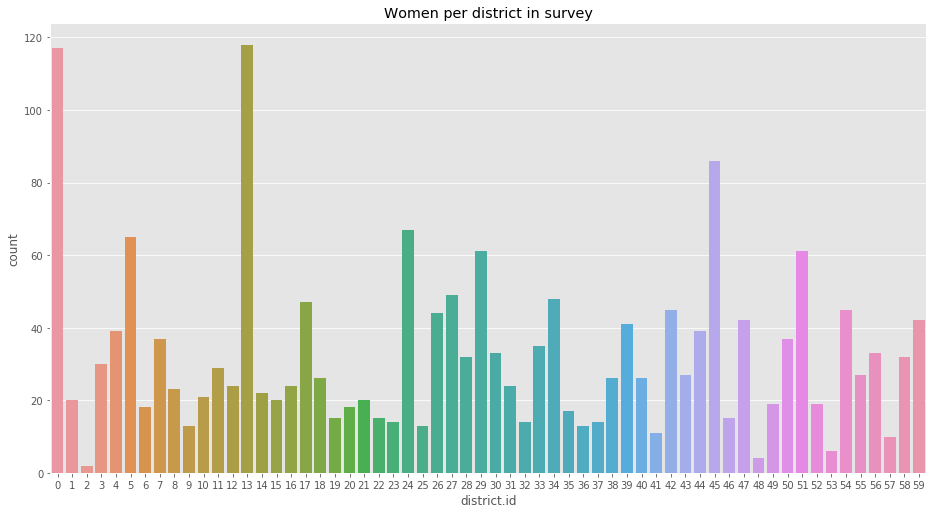

In [5]:
fig, ax = plt.subplots()
fig.set_size_inches(15.7, 8.27)

_ = sns.countplot('district.id', data=data, ax=ax).set_title('Women per district in survey')

We see quite a big variation in the size of the districts. Some districts have many women (e.g. `district.id==0`), while others have almost no observations (e.g. `district.id==2`). We also have 59 districts.

/home/karma/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


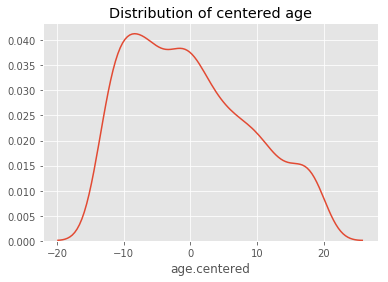

In [6]:
_ = sns.distplot(data['age.centered'], hist=False).set_title('Distribution of centered age')

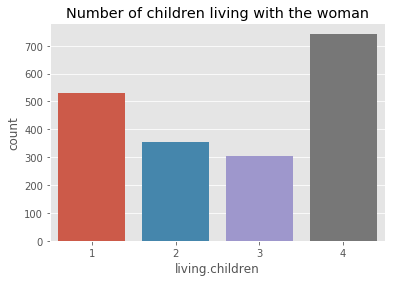

In [7]:
_ = sns.countplot('living.children', data=data).set_title('Number of children living with the woman')

Number of living children is weird, looks like `living.children==4` corresponds to "three or more children".

Next we will explore how contraception use varies for a few of the factors in the dataset.

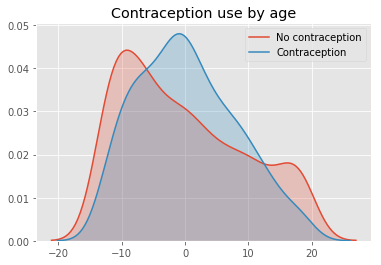

In [8]:
def plotDensity(varname = 'age.centered', 
                title = 'Contraception use by age'):
    sns.kdeplot(data[varname][data['use.contraception']==0], label='No contraception', shade=True)
    sns.kdeplot(data[varname][data['use.contraception']==1], label='Contraception', shade=True)
    plt.title(title)
    plt.show()
    
plotDensity()

We can see the that on average, the population of women using contraception is higher than those not using contraception. We also see in the tails that the oldest and youngest women are less likely to use contraception.

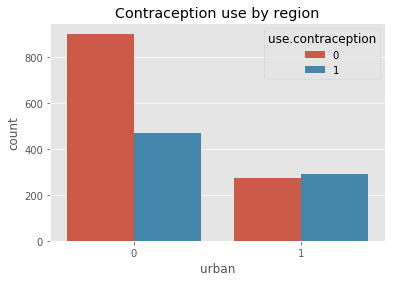

In [9]:
sns.countplot("urban", hue="use.contraception", data=data)
plt.title('Contraception use by region')
plt.show()

As noted earlier, we have a higher representation of rural respondants in the survey. We can see here however, that within urban regions, women appear equally likely to use or not use contraception. On the other hand, women in rural areas are much less likely to use contraception.

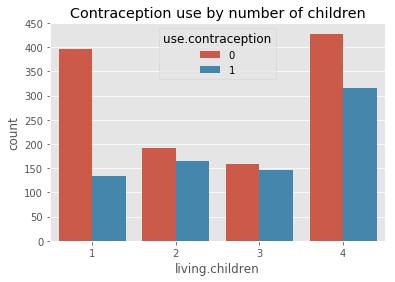

In [10]:
sns.countplot("living.children", hue="use.contraception", data=data)
plt.title('Contraception use by number of children')
plt.show()

We see above that women with just 1 child or many children are more likely to use contraception than not.

## Part A

We will use `use.contraception` as a Bernoulli response variable. 

When we say "fit" below, we mean, specify the model, plot its graph, sample from it, do some tests, and forest-plot and summarize the posteriors, at the very least.

**A1** Fit a traditional "fixed-effects" model which sets up district-specific intercepts, each with its own Normal(0, 10) prior. That is, the intercept is modeled something like 

```python
alpha_district = pm.Normal('alpha_district', 0, 10, shape=num_districts)
p=pm.math.invlogit(alpha_district[df.district_id])
```

Why should there not be any overall intercept in this model? 

**A2** Fit a multi-level "varying-effects" model with an overall intercept `alpha`, and district-specific intercepts `alpha_district`. Assume that the overall intercept has a Normal(0, 10) prior, while the district specific intercepts are all drawn from the **same** normal distribution with mean 0 and standard deviation $\sigma$. Let $\sigma$ be drawn from HalfCauchy(2). The setup of this model is similar to the per-chimanzee models in the prosocial chimanzee labs.

**A3** What does a posterior-predictive sample in this model look like? What is the difference between district specific posterior predictives and woman specific posterior predictives. In other words, how might you model the posterior predictive for a new woman being from a particular district vs that os a new woman in the entire sample? This is a word answer; no programming required.

**A4** Plot the predicted proportions of women in each district using contraception against the id of the district, in both models. How do these models disagree? Look at the extreme values of predicted contraceptive use in the fixed effects model. How is the disagreement in these cases?

**A5** Plot the absolute value of the difference in probability of contraceptive use against the number of women sampled in each district. What do you see?

> **A1** Fit a traditional "fixed-effects" model which sets up district-specific intercepts, each with its own Normal(0, 10) prior. That is, the intercept is modeled something like 

```python
alpha_district = pm.Normal('alpha_district', 0, 10, shape=num_districts)
p=pm.math.invlogit(alpha_district[df.district_id])
```
> Why should there not be any overall intercept in this model? 

In [11]:
num_districts = data.district.nunique()

with pm.Model() as fixed_model:
    alpha_district = pm.Normal('alpha_district', 0, 10, shape=num_districts)
    
    p = pm.math.invlogit(alpha_district[data['district.id']])
    obs = pm.Bernoulli('obs', p=p, observed=data['use.contraception'])
    
    trace_fixed = pm.sample()

/home/karma/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/karma/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_district]
Sampling 4 chains:   0%|          | 0/4000 [00:00<?, ?draws/s]

All statistics, autocorrelation plots, etc. look good (not shown here), so we trust the results.

There should be no overall intercept, because we fit a mean separately for every district. Adding an overall mean would mean that we get a non-identifiable model (in this case corresponding to a design matrix having a non-trivial linear relationship).

> *A2** Fit a multi-level "varying-effects" model with an overall intercept `alpha`, and district-specific intercepts `alpha_district`. Assume that the overall intercept has a Normal(0, 10) prior, while the district specific intercepts are all drawn from the **same** normal distribution with mean 0 and standard deviation $\sigma$. Let $\sigma$ be drawn from HalfCauchy(2). The setup of this model is similar to the per-chimanzee models in the prosocial chimanzee labs.

In [12]:
with pm.Model() as varying_model:
    α = pm.Normal('alpha', 0, 10)
    
    σ = pm.HalfCauchy('sigma', 2)
    α_district = pm.Normal('alpha_district', 0, σ, shape=num_districts)
    
    p = pm.math.invlogit(α + α_district[data['district.id']])
    
    obs = pm.Bernoulli('obs', p=p, observed=data['use.contraception'])
    
    trace_varying = pm.sample()

/home/karma/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/karma/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_district, sigma, alpha]
Sampling 4 chains: 100%|██████████| 4000/4000 [0

Again, all diagnostics look good (good `n_eff`, $\hat R$ values, no divergences, no obvious patterns in trace, etc.).

> **A3** What does a posterior-predictive sample in this model look like? What is the difference between district specific posterior predictives and woman specific posterior predictives. In other words, how might you model the posterior predictive for a new woman being from a particular district vs that os a new woman in the entire sample? This is a word answer; no programming required.

Replicating the whole dataset using the posterior amounts to drawing a new observation `use.contraception` for every woman in the sample. In particular in this replicated dataset we have the same number of women in every district as we have in the orignal datatset.

The **(1) district-specific posterior** assumes that we know that the new woman is from `district.id==i`. This means that we get the posterior by district with value $\alpha + \alpha_{district}[i]$ **with $i$ known**.

If we don't know the district, we obtain the **(2) overall posterior predictive** by **first sampling a `district_id` j** and then sampling $\alpha[j]$. We repeat this composite process. The sampling of a district is done proportional to the counts of the district.

We expect **(2)** to be a much wider, i.e. much more uncertain in the predictions.

> **A4** Plot the predicted proportions of women in each district using contraception against the id of the district, in both models. How do these models disagree? Look at the extreme values of predicted contraceptive use in the fixed effects model. How is the disagreement in these cases?

In [13]:
trace_varying.varnames

['alpha', 'sigma_log__', 'alpha_district', 'sigma']

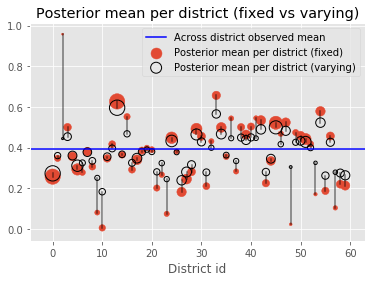

In [14]:
district_counts = data['district.id'].value_counts().sort_index()
overall_mean = data['use.contraception'].mean()

y_fixed = scipy.special.expit(trace_fixed['alpha_district']).mean(axis=0)   
y_varying = scipy.special.expit(trace_varying['alpha_district'] + trace_varying['alpha'].reshape(-1, 1)).mean(axis=0)

fig, ax = plt.subplots(1, 1)

x = data['district.id'].unique()
size = district_counts * 2

ax.scatter(x, y_fixed, s=size, label='Posterior mean per district (fixed)')
ax.scatter(x, y_varying, s=size, label='Posterior mean per district (varying)',
           facecolors='none', edgecolors='k', lw=1)

ax.plot([x, x], [y_fixed, y_varying], 'k-', alpha=.5)
ax.axhline(y=overall_mean, c='blue', label='Across district observed mean')
plt.title('Posterior mean per district (fixed vs varying)')
plt.xlabel('District id')
_ = ax.legend()


The main difference comes from the **small districts**. Look, for example, at the left-most point, `district_id==0`. This is a very big district and the two models pretty much agree.

On the other hand, if we look at the very small districts, for example `district_id==2`, which has three women and an observed rate of $3/3=1$, this model get regularized to below 0.5 in the "random effects" model, whereas it stays close to 1.0 in the fixed effects model. Looking at other small districts, we can see that the posterior means are much more extreme from the fixed effects model.

So, the random effects model needs more evidence to be convinced and is thus more conservative in that sense.
We also observe that almost every small district is being moved towards the overall mean. The further from the mean it is, the heavier it is regularised.

> **A5** Plot the absolute value of the difference in probability of contraceptive use against the number of women sampled in each district. What do you see?

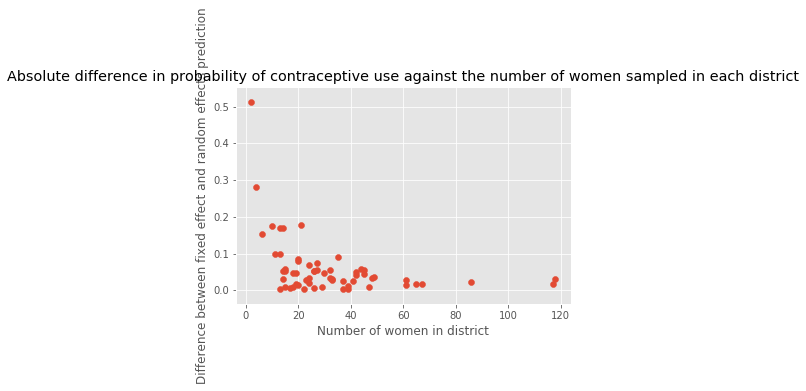

In [15]:
ys_fx = scipy.special.expit(trace_fixed['alpha_district']).mean(axis=0)
ys_rx = scipy.special.expit(trace_varying['alpha'].reshape(-1, 1) + trace_varying['alpha_district']).mean(axis=0)
diff = np.abs(ys_fx - ys_rx)

fig, ax = plt.subplots(1, 1)
ax.scatter(district_counts, diff)
ax.set_ylabel("Difference between fixed effect and random effects prediction")
ax.set_xlabel("Number of women in district")
ax.set_title('Absolute difference in probability of contraceptive use against the number of women sampled in each district')
plt.show()

We see the clear trend that the difference becomes smaller the more observartions we have in a given district. The very small districts get regularized heavily.

## Part B.

Let us now fit a model with both varying intercepts by `district_id` (like we did in the varying effects model above) and varying slopes of `urban` by `district_id`. To do this, we will 

- (a) have an overall intercept, call it `alpha`
- (b) have an overall slope of `urban`, call it `beta`.
- (c) have district specific intercepts `alpha_district`
- (d) district specific slopes for `urban`, `beta_district`
- (e) model the co-relation between these slopes and intercepts. 

We have not modelled covariance and correlation before, so look at http://am207.info/wiki/corr.html for notes on how this is done.

To see the ideas behind this, see section 13.2.2 on the income data  from your textbook (included as a pdf in this zip). Feel free to use [code with attribution from Osvaldo Martin](https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3/blob/master/Chp_13.ipynb)..with attribution and understanding...there is some sweet pymc3 technical wrangling in there.

**B1** Write down the model as a pymc3 specification and look at its graph. Note that this model builds a 60 by 2 matrix with `alpha_district` values in the first column and `beta_district` values in the second. By assumption, the first column and the second column have correlation structure given by an LKJ prior, but there is no explicit correlation among the rows. In other words, the correlation matrix is 2x2 (not 60x60). Make sure to obtain the value of the off-diagonal correlation as a `pm.Deterministic`. (See Osvaldo Martin's code above)

**B2**: Sample from the posterior of the model above *with a target acceptance rate of .9 or more*. (Sampling takes me 7 minutes 30 seconds on my 2013 Macbook Air). Comment on the quality of the samples obtained.

**B3** Propose a method based on the reparametrization trick for multi-variate gaussians) of improving the quality of the samples obtained and implement it. (A hint can be obtained from here: https://docs.pymc.io/api/distributions/multivariate.html#pymc3.distributions.multivariate.MvNormal . Using that hint lowered the sampling time to 2.5 minutes on my laptop).

**B4** Inspect the trace of the correlation between the intercepts and slopes, plotting the correlation marginal. What does this correlation tell you about the pattern of contraceptive use in the sample? It might help to plot the mean (or median) varying effect estimates for both the intercepts and slopes, by district. Then you can visualize the correlation and maybe more easily think through what it means to have a particular correlation. Also plot the predicted proportion of women using contraception, with urban women on one axis and rural on the other.  Finally, also plot the difference between urban and rural probabilities against rural probabilities. All of these will help you interpret your findings. (Hint: think in terms of low or high rural contraceptive use)

**B5** Add additional "slope" terms (one-by-one) into the model for 

- (a) the centered-age of the women and 
- (b) an indicator for whether the women have a small number or large number of existing kids in the house (you can treat 1-2 kids as low, 3-4 as high, but you might want to experiment with this split). 

Are any of these effects significant? Are any significant effects similar over the urban/rural divide?

**B6** Use WAIC to compare your models. What are your conclusions?

> **B1** Write down the model as a pymc3 specification and look at its graph. Note that this model builds a 60 by 2 matrix with `alpha_district` values in the first column and `beta_district` values in the second. By assumption, the first column and the second column have correlation structure given by an LKJ prior, but there is no explicit correlation among the rows. In other words, the correlation matrix is 2x2 (not 60x60). Make sure to obtain the value of the off-diagonal correlation as a `pm.Deterministic`. (See Osvaldo Martin's code above)

We take Osvaldo Martin's code (13.19) from above and modify it slightly. We will abstract into a base class to minimise code duplication.

In [16]:
with pm.Model() as fit:
    sd_dist = pm.HalfCauchy.dist(beta=2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)

    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = tt.dot(chol, chol.T)

    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma_dept', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])

    # Overall
    α = pm.Normal('alpha', 0, 10) #intercept
    β = pm.Normal('beta', 0, 1) #slope of urban   
    
    mu = pm.MvNormal('vals', mu=tt.stack([α, β]), chol=chol, shape=(num_districts, 2))

    α_district = pm.Deterministic('alpha_district', mu[:, 0])
    β_district = pm.Deterministic('beta_district', mu[:, 1])

    p = pm.math.invlogit(mu[data['district.id'], 0] + mu[data['district.id'], 1] * data['urban'])
    obs = pm.Bernoulli('observed', p=p, observed=data['use.contraception'])

    

_ = pm.model_to_graphviz(fit)

/home/karma/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/karma/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/karma/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In 

>**B2**: Sample from the posterior of the model above *with a target acceptance rate of .9 or more*. (Sampling takes me 7 minutes 30 seconds on my 2013 Macbook Air). Comment on the quality of the samples obtained.

In [17]:
with fit:
    trace = pm.sample(1000, tune=1000, njobs=4, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/karma/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/karma/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/karma/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing i

We check that we get sensible results. To that end, we start by extracting samples for the posterior predictive check:

In [18]:
with fit:
    ppc = pm.sample_ppc(trace=trace, samples=500)

  0%|          | 0/500 [00:00<?, ?it/s]/home/karma/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
100%|██████████| 500/500 [00:00<00:00, 801.78it/s]


/home/karma/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


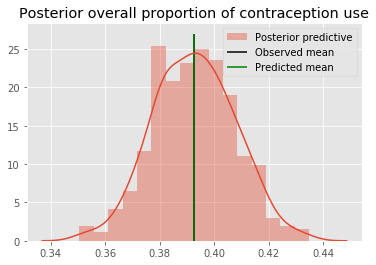

In [19]:
def plot_pp():    
    sns.distplot(ppc['observed'].mean(axis=1), label='Posterior predictive')
    plt.vlines(x=data['use.contraception'].mean(), ymin=0, ymax=27, label='Observed mean')
    plt.vlines(x=ppc['observed'].mean(axis=1).mean(), ymin=0, ymax=27, label='Predicted mean', colors='green')
        
    plt.legend()
    plt.title('Posterior overall proportion of contraception use')
    plt.show()
    
plot_pp()

We can see that the predicted mean is close to the observed mean. However, regarding the quality of the sample, we also note the small number of effective samples, and the divergence after tuning, which motivates **B3**

> **B3** Propose a method based on the reparametrization trick for multi-variate gaussians) of improving the quality of the samples obtained and implement it. (A hint can be obtained from here: https://docs.pymc.io/api/distributions/multivariate.html#pymc3.distributions.multivariate.MvNormal . Using that hint lowered the sampling time to 2.5 minutes on my laptop).

The reparametrization trick used here is actually quite similar to the one used in the lecture. It's basically a mutlivariate version thereof. Instead of doing the multiplication by $\sigma$ only, we take the matrix product with the square root of the covariance matrix.

In [20]:
with pm.Model() as fit_rep:
    # Overall
    α = pm.Normal('alpha', 0, 10)
    β = pm.Normal('beta', 0, 1)
    
    sd_dist = pm.HalfCauchy.dist(beta=2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = tt.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma_dept', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    # Put in joint distribution
    vals_raw = pm.Normal('vals_raw', mu=0, sd=1, shape=(num_districts, 2))
    mu = pm.Deterministic('vals', tt.stack([α, β]) + tt.dot(chol, vals_raw.T).T)
    
    α_district = pm.Deterministic('alpha_district', mu[:, 0])
    β_district = pm.Deterministic('beta_district', mu[:, 1])
    
    p = pm.math.invlogit(mu[data['district.id'], 0] + mu[data['district.id'], 1] * data['urban'])
    obs = pm.Bernoulli('observed', p=p, observed=data['use.contraception'])
    
    trace_rep = pm.sample(1000, tune=1000, njobs=4, target_accept=0.95)

/home/karma/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/karma/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/karma/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future thi

In [21]:
with fit_rep:
    ppc = pm.sample_ppc(trace=trace_rep, samples=500)

100%|██████████| 500/500 [00:00<00:00, 810.85it/s]


The overall mean is in line with the observed mean:

In [22]:
ppc['observed'].mean()

0.39235263702171663

In [23]:
data['use.contraception'].mean()

0.3924508790072389

Again, we can plot this

/home/karma/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


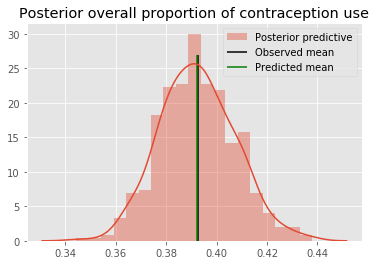

In [24]:
plot_pp()

We can see that the predicted mean is pretty much spot on the observed mean, and certainly closer than when we didnt use the reparamaterization trick,

We check that we also get a sensible agreement within districts:

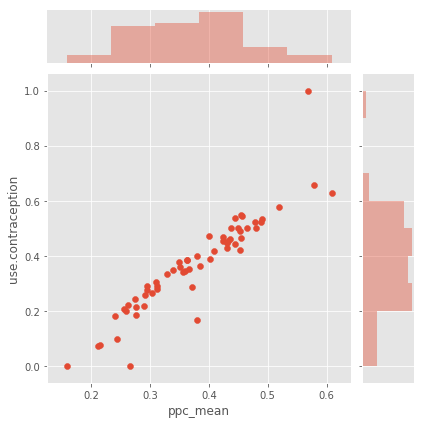

In [25]:
data['ppc_mean'] = ppc['observed'].mean(axis=0)
foo = data.groupby('district')[['use.contraception', 'ppc_mean']].mean()

sns.jointplot('ppc_mean', 'use.contraception', data=foo)
plt.show()

The above plot shows that we fit the observed value of `use.contraception` well within districts. The "outlier" above is a very small district with 3 observations.

> **B4** Inspect the trace of the correlation between the intercepts and slopes, plotting the correlation marginal. What does this correlation tell you about the pattern of contraceptive use in the sample? It might help to plot the mean (or median) varying effect estimates for both the intercepts and slopes, by district. Then you can visualize the correlation and maybe more easily think through what it means to have a particular correlation. Also plot the predicted proportion of women using contraception, with urban women on one axis and rural on the other.  Finally, also plot the difference between urban and rural probabilities against rural probabilities. All of these will help you interpret your findings. (Hint: think in terms of low or high rural contraceptive use)

We start by plotting the marginal distribution and the trace.

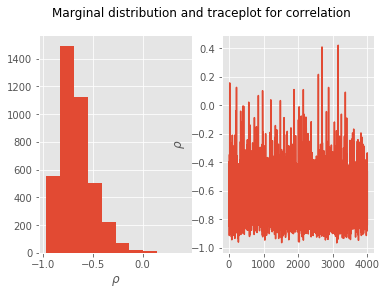

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2)

plt.suptitle("Marginal distribution and traceplot for correlation")

ax1.hist(trace_rep['Rho'])
ax1.set_xlabel(r"$\rho$")

ax2.plot(trace_rep['Rho'])
ax2.set_ylabel(r"$\rho$")
plt.show()

We see a rather strong **negative correlation** between the two coefficients. This means that in districts with high use of contraception, the difference between rural and urban is less pronounced.

Let's plot the mean $\alpha_{district}$ and $\beta_{district}$ against each other. The plot confirms the correlation we saw above.

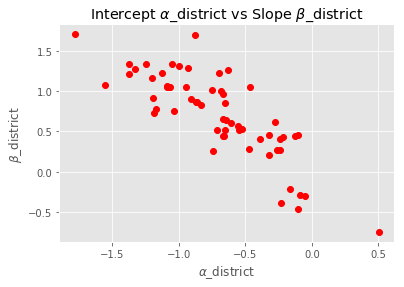

In [27]:
alpha_means = trace_rep['alpha_district'].mean(axis=0)
beta_means = trace_rep['beta_district'].mean(axis=0)

plt.plot(alpha_means, beta_means, 'ro')
plt.xlabel(r"$\alpha$_district")
plt.ylabel(r"$\beta$_district")
plt.title(r'Intercept $\alpha$_district vs Slope $\beta$_district')
plt.show()

Let's also plot the average of both coefficents by district ID so that we get a better feel. For most districts, we see that the average value of $\beta_{district}$ is above zero, meaning the in urban districts, contraceptives tend to be used more.

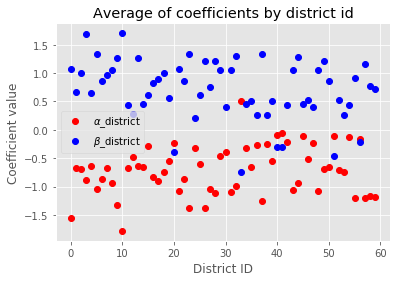

In [28]:
plt.plot(data['district.id'].unique(), trace_rep['alpha_district'].mean(axis=0), 'ro', label=r'$\alpha$_district')
plt.plot(data['district.id'].unique(), trace_rep['beta_district'].mean(axis=0), 'bo', label=r'$\beta$_district')
plt.xlabel("District ID")
plt.ylabel("Coefficient value")
plt.legend()
plt.title('Average of coefficients by district id')
plt.show()

Next, we plot the average probabilities for rural and urban district by District.

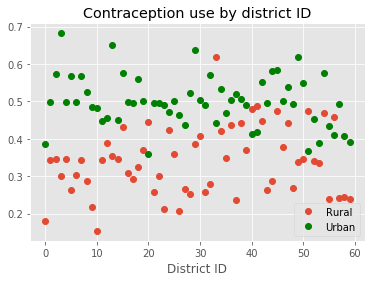

In [29]:
p_rural = scipy.special.expit(trace_rep['alpha_district']).mean(axis=0)
p_urban = scipy.special.expit(trace_rep['alpha_district'] + trace_rep['beta_district']).mean(axis=0)

plt.title("Contraception use by district ID")
plt.plot(p_rural, 'o', label='Rural')
plt.plot(p_urban, 'go', label='Urban')
plt.xlabel("District ID")
plt.legend()
plt.show()

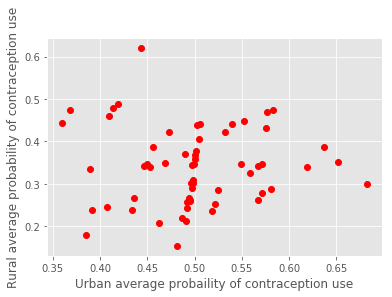

In [30]:
p_rural = scipy.special.expit(trace_rep['alpha_district']).mean(axis=0)
p_urban = scipy.special.expit(trace_rep['alpha_district'] + trace_rep['beta_district']).mean(axis=0)

fig, ax = plt.subplots()
plt.plot(p_urban, p_rural, 'ro')
plt.xlabel("Urban average probaility of contraception use")
plt.ylabel("Rural average probability of contraception use")
plt.show()

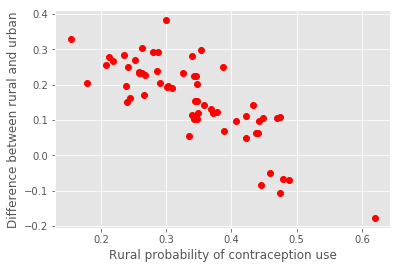

In [31]:
p_rural = scipy.special.expit(trace_rep['alpha_district']).mean(axis=0)
p_urban = scipy.special.expit(trace_rep['alpha_district'] + trace_rep['beta_district']).mean(axis=0)

plt.plot(p_rural, p_urban - p_rural, 'ro')
plt.xlabel("Rural probability of contraception use")
plt.ylabel("Difference between rural and urban")
plt.show()

We also see the negative correlation in the last plot above: the higher the rural average of contraception use, the lower the difference between rural and urban.

> **B5** Add additional "slope" terms (one-by-one) into the model for 

> - (a) the centered-age of the women and 
> - (b) an indicator for whether the women have a small number or large number of existing kids in the house (you can treat 1-2 kids as low, 3-4 as high, but you might want to experiment with this split). 

> Are any of these effects significant? Are any significant effects similar over the urban/rural divide?

#### Preparatory analysis

Before blindly building a model, let's check what to expect. We split the data `many.kinds` and calculate both the posterior predictive mean and the observed mean of `use.contraception`. We see that there is a significant misfit (actually the `ppc_mean` could only indirectly adadpt, via the `district.id`).

In [32]:
data.groupby('many.kids')[['ppc_mean', 'use.contraception']].mean()

,ppc_mean,use.contraception
many.kids,,
0,0.394758,0.250943
1,0.391444,0.445869


For the age, we first bin the age into 5 categories and compute the contraception use within each bin. Again, there's evidence that there's a pattern we didn't see yet. Interestingly, it looks as if it will be hard to match the observed pattern with a *linear* model in age, as the use of contraception is low both for the youngest and oldest women. We'll go ahead and fit it nevertheless.

In [33]:
data['age.binned'] = pd.cut(data['age.centered'], bins=5)
data.groupby('age.binned')[['ppc_mean', 'use.contraception']].agg({'mu': np.mean, 'n': len})

/home/karma/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


mu                          n                  
                  ppc_mean use.contraception ppc_mean use.contraception
age.binned                                                             
(-13.593, -6.96]  0.393636          0.293561    528.0               528
(-6.96, -0.36]    0.391885          0.456814    521.0               521
(-0.36, 6.24]     0.400280          0.482480    371.0               371
(6.24, 12.84]     0.396201          0.446309    298.0               298
(12.84, 19.44]    0.371417          0.250000    216.0               216

Let's also plot the observed relationship using a `lowess` fit. It's clear that, at least marginally, we cannot fit this relationship reasonably with a linear model.

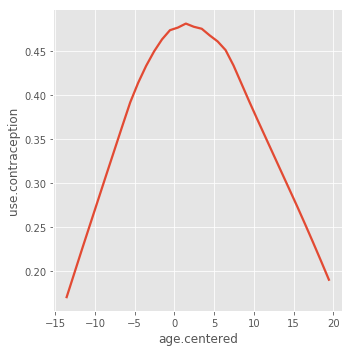

In [34]:
_ = sns.lmplot('age.centered', 'use.contraception', data=data, lowess=True, scatter=False)

#### Fitted model

Now, we go ahead and fit the model:

In [35]:
with pm.Model() as fit_age:
    # Overall
    α = pm.Normal('alpha', 0, 10)
    β = pm.Normal('beta', 0, 1)
    β_age = pm.Normal('beta_age', 0, 10)
    
    
    sd_dist = pm.HalfCauchy.dist(beta=2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = tt.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma_dept', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    # Put in joint distribution
    vals_raw = pm.Normal('vals_raw', mu=0, sd=1, shape=(num_districts, 2))
    mu = pm.Deterministic('vals', tt.stack([α, β]) + tt.dot(chol, vals_raw.T).T)
    
    α_district = pm.Deterministic('alpha_district', mu[:, 0])
    β_district = pm.Deterministic('beta_district', mu[:, 1])
    
    p = pm.math.invlogit(mu[data['district.id'], 0] + mu[data['district.id'], 1] * data['urban'] + \
                        β_age * data['age.centered'])
    obs = pm.Bernoulli('observed', p=p, observed=data['use.contraception'])
    
    trace_age = pm.sample(1000, tune=1000, njobs=4, target_accept=0.95)

/home/karma/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/karma/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/karma/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In 

/home/karma/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


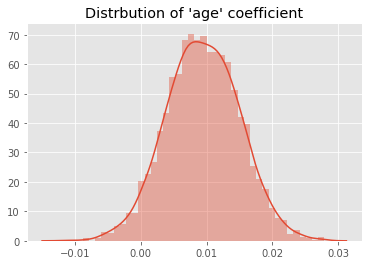

In [36]:
_ = sns.distplot(trace_age['beta_age']).set_title("Distrbution of 'age' coefficient")

The age coefficient has a its probability centered around 0.01, but the distribution is not far away from zero. It's not significant in that sense, although a lot of the probability mass is positive. A result like this was to be expected from the exploratory analysis above.

Next, let's move on the the model with kids (we keep the split at 2, as suggested).

In [37]:
with pm.Model() as fit_kids:
    # Overall
    α = pm.Normal('alpha', 0, 10)
    β = pm.Normal('beta', 0, 1)
    β_kids = pm.Normal('beta_kids', 0, 10)
    
    
    sd_dist = pm.HalfCauchy.dist(beta=2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = tt.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma_dept', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    # Put in joint distribution
    vals_raw = pm.Normal('vals_raw', mu=0, sd=1, shape=(num_districts, 2))
    mu = pm.Deterministic('vals', tt.stack([α, β]) + tt.dot(chol, vals_raw.T).T)
    
    α_district = pm.Deterministic('alpha_district', mu[:, 0])
    β_district = pm.Deterministic('beta_district', mu[:, 1])
    
    p = pm.math.invlogit(mu[data['district.id'], 0] + mu[data['district.id'], 1] * data['urban'] + \
                        β_kids * data['many.kids'])
    obs = pm.Bernoulli('observed', p=p, observed=data['use.contraception'])
    
    trace_kids = pm.sample(1000, tune=1000, njobs=4, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vals_raw, chol_cov, beta_kids, beta, alpha]
Sampling 4 chains: 100%|██████████| 8000/8000 [01:13<00:00, 108.25draws/s]


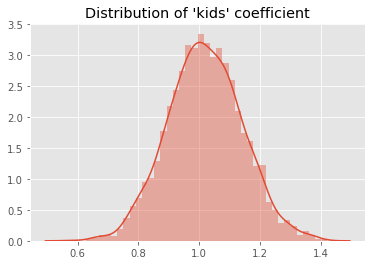

In [38]:
_ = sns.distplot(trace_kids['beta_kids']).set_title("Distribution of 'kids' coefficient")

We see that the coefficient for many kids is centered around 1. This means, that holding everything else constant, women with many kids tend to use contraception more.

The difference seems to be *bigger* in rural areas on a logistic scale (so we'd probably get a "significant" interaction effect).

In [39]:
with fit_kids:
    ppc = pm.sample_ppc(trace=trace_kids, samples=500)

data['ppc_mean_kids'] = ppc['observed'].mean(axis=0)
data.groupby(['urban', 'many.kids'])[['ppc_mean_kids', 'use.contraception']].mean().apply(scipy.special.logit)

  0%|          | 0/500 [00:00<?, ?it/s]/home/karma/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/karma/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
100%|██████████| 500/500 [00:00<00:00, 573.28it/s]


ppc_mean_kids  use.contraception
urban many.kids                                  
0     0              -1.396639          -1.493925
      1              -0.433841          -0.412882
1     0              -0.598057          -0.430036
      1               0.340917           0.277273

In [40]:
with pm.Model() as fit_kids_interaction:
    # Overall
    α = pm.Normal('alpha', 0, 10)
    β = pm.Normal('beta', 0, 1)
    β_kids = pm.Normal('beta_kids', 0, 10)
    β_kids_urban = pm.Normal('beta_kids_urban', 0, 10)
    
    sd_dist = pm.HalfCauchy.dist(beta=2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = tt.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma_dept', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    # Put in joint distribution
    vals_raw = pm.Normal('vals_raw', mu=0, sd=1, shape=(num_districts, 2))
    mu = pm.Deterministic('vals', tt.stack([α, β]) + tt.dot(chol, vals_raw.T).T)
    
    α_district = pm.Deterministic('alpha_district', mu[:, 0])
    β_district = pm.Deterministic('beta_district', mu[:, 1])
    
    p = pm.math.invlogit(mu[data['district.id'], 0] + mu[data['district.id'], 1] * data['urban'] + \
                        β_kids * data['many.kids'] + β_kids_urban * data['many.kids'] * data['urban'])
    obs = pm.Bernoulli('observed', p=p, observed=data['use.contraception'])
    
    trace_kids_interaction = pm.sample(1000, tune=1000, njobs=4, target_accept=0.95)

/home/karma/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/karma/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/karma/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing i

The interaction coefficient, by construction, explains this difference between rural and urban:

/home/karma/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


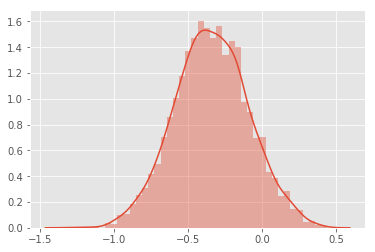

In [41]:
sns.distplot(trace_kids_interaction['beta_kids_urban'])

> **B6** Use WAIC to compare your models. What are your conclusions?

In [42]:
fit_rep.name = 'Basic'
fit_kids.name = 'With many kids'
fit_age.name = 'With age'
fit_kids_interaction.name = 'With many kids and rural interaction'

df_comp_WAIC = pm.compare({fit_rep: trace_rep, fit_age: trace_age, fit_kids: trace_kids, 
                           fit_kids_interaction: trace_kids_interaction})
df_comp_WAIC

/home/karma/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/karma/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/karma/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`.

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
With many kids,2394.47,54.62,0,0.53,31.76,0,0
With many kids and rural interaction,2394.63,55.45,0.16,0.46,31.74,2.76,0
With age,2466.66,54.09,72.19,0,28.37,15.52,0
Basic,2468.99,53.02,74.51,0.01,28.13,16.91,0


From the WAIC computation, we see most of the weight goes in the interaction model. The remaining weight goes into the model with `many.kids` and the basic model. 

We also did the comparison without the interaction model. In that case, **all the weight goes into the model with `many.kids` included**. From the point of view of model accuracy we should use the model with `many.kids` (or with the interaction).

For fun's sake, let's also fit a model that tries to capture the quadratic relationship between contraception use and age:

In [43]:
with pm.Model() as complete_fit:
    # Overall
    α = pm.Normal('alpha', 0, 10)
    β = pm.Normal('beta', 0, 1)
    β_kids = pm.Normal('beta_kids', 0, 10)
    β_kids_urban = pm.Normal('beta_kids_urban', 0, 10)
    β_age = pm.Normal('beta_age', 0, 10)
    β_age_sq = pm.Normal('beta_age_sq', 0, 10)
    
    
    sd_dist = pm.HalfCauchy.dist(beta=2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = tt.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma_dept', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    # Put in joint distribution
    vals_raw = pm.Normal('vals_raw', mu=0, sd=1, shape=(num_districts, 2))
    mu = pm.Deterministic('vals', tt.stack([α, β]) + tt.dot(chol, vals_raw.T).T)
    
    α_district = pm.Deterministic('alpha_district', mu[:, 0])
    β_district = pm.Deterministic('beta_district', mu[:, 1])
    
    p = pm.math.invlogit(mu[data['district.id'], 0] + mu[data['district.id'], 1] * data['urban'] + \
                        β_kids * data['many.kids'] + β_kids_urban * data['many.kids'] * data['urban'] + \
                        β_age * data['age.centered'] + β_age_sq * data['age.centered'] ** 2)
    obs = pm.Bernoulli('observed', p=p, observed=data['use.contraception'])
    
    trace_complete = pm.sample(1000, tune=1000, njobs=4, target_accept=0.95)

/home/karma/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/karma/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/karma/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing i

All trace statistics look good. We see that the squared age coefficient is far away from zero.

/home/karma/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/karma/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fabf21014a8>,
      dtype=object)

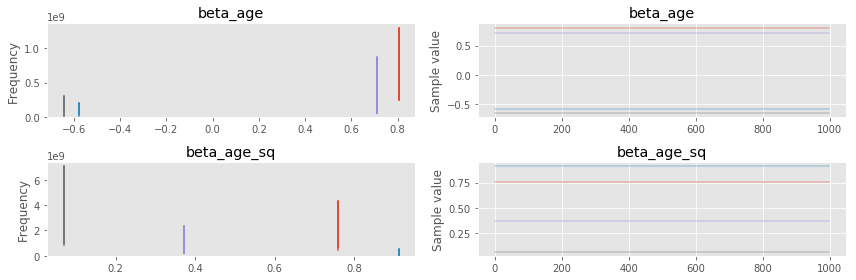

In [44]:
pm.traceplot(trace_complete, varnames=['beta_age', 'beta_age_sq'])

This model gives a lot of improvement again and makes almost all the weight go into this model.

In [45]:
complete_fit.name = 'All coefs and age squared'

df_comp_WAIC = pm.compare({fit: trace_rep, fit_age: trace_age, fit_kids: trace_kids, 
                           fit_kids_interaction: trace_kids_interaction,
                           complete_fit: trace_complete})
df_comp_WAIC

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
With many kids and rural interaction,2394.47,54.62,0,0.53,31.76,0,0
All coefs and age squared,2394.63,55.45,0.16,0.46,31.74,2.76,0
With many kids,2466.66,54.09,72.19,0,28.37,15.52,0
With age,2468.99,53.02,74.51,0.01,28.13,16.91,0


We checked that all the conclusions drawn from the simpler model still hold for this more complex model. Depending on our concrete interest, this model may actually be overkill.

## Q2: Mixture of experts and mixture density networks to solve inverse problems

What if you had to predict a one-to-many function? The data provided below comes from a dataset generated by Chris Bishop (yes that Bishop) to explain the models mentioned in the title above. We have included pdfs from his book which describe these models in some detail. We saw this model earlier in HW where we did an EM like algorithm to obtain a mixture of regressions.

The data is in `one-to-many.csv`

When we plot the data it looks like this. Notice both the uneven sampling (more towards the center), and the "more than one y" for a given x.

![](images/inverse.png)

Normal regression approaches to modeling such a function wont work, as they expect the function to be a proper mathematical function, that is, single valued.

These kind of problems are called **inverse problems**, where more than one input state leads to an output state, and we have to try and model these multiple input states.

A mixture of gaussians (or other distributions) might is a sensible way to do this.

You choose one of the gaussians with some probability. The nean of the gaussian is then given by some regression function, say for example a straight line. We could additionally fix the standard deviation or model it as well. 

Thus, for each component Gaussian, we choose a functional form for the mean and standard deviation. So our model looks something like this:

$$f(x)  = \sum_i \lambda_i g_i (x) $$

Say we fit a model with 3 gaussians to this data. Such a model cannot fit the function above. Notice for example that at $x=0.2$ only one of the gaussians will dominate, different from the situation at $x=0.5$. This means that the probabilities of "belonging" to one or the other gaussians is also changing with $x$.

If we allow the mixing probabilities to depend on $x$, we can model this situation.

$$f(x)  = \sum_i \lambda_i (x) g_i (x) $$

Such a model is called a "mixture of experts" model. The idea is that one "expert" gaussian is responsible in one sector of the feature space, while another expert is responsible in another sector.

You can think of this model as implementing a "standard" gaussian mixture at each "point" x, with the added complexity that all of the means, standard deviations, and mixture probabilities change from one x to another.

See https://www.cs.toronto.edu/~hinton/absps/hme.pdf and http://www.ee.hacettepe.edu.tr/~eyuksel/Publications/2012_TwentyYearsofMixtureofExperts.pdf for more details. I found the latter clearer and easier to understand.

For this entire question you might find diagram code from [here](https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb) useful. Take with attribution.

We will assume we have **3 gaussians**.

## Part A: Variational Mixture of experts

We'll construct a gaussian mixture model of 3 "expert" linear regressions. The idea is to create a fit which looks like this:

![](images/mixreg.png)

Here the three regression lines work in different regions of $f$. We want a pricipled way to sample from this model and to be able to produce posteriors and posterior-predictives.

There are 3 parts to this model. First the means of the gaussians in the mixture are modeled with linear regression as shown in the picture above. We will also model $log(\sigma)$ for each gaussian in the mixture as a linear regression as well ($\sigma$ needs to be positive).

We now need to model the mixture probabilities, i.e., the probabilities required to choose one or the other gaussian. These mixing probabilities, the $\lambda$s will be modeled as a softmax regression (ie do a linear regression and softmax it to get 3 probabilities).

**A1** Write a pymc3 model for this problem. For all biases and weights in your regressions, assume N(0,5) priors. Add noise 0.01 to each of the three $\sigma$s to make sure you dont have a collapsed 0 width gaussian, ie we want some data in every cluster. (Thus to get the final $\sigma$, you will exponentiate your regression for $log(\sigma)$ and add 0.01.)

**A2** Fit this model variationally for about 50,000 iterations using the adam optimizer. (`obj_optimizer=pm.adam()`) Plot the ELBO to make sure you have converged. Print summaries and traceplots for the means, $\sigma$s and probabilities.

**A3** Plot the mean posteriors with standard deviations against x. Also produce a diagram like the one above to show the mean"s with standard deviations showing their uncertainty overlaid on the data.

**A4** Plot the posterior predictive (mean and variance) as a function of x) for this model (using `sample_ppc` for example). Why does the posterior predictive look nothing like the data?

**A5** Make a "correct" posterior predictive diagram by taking into account which "cluster" or "regression line" the data is coming from. To do this you will need to sample using the softmax probabilities. A nice way to do this is "Gumbel softmax sampling". See http://timvieira.github.io/blog/post/2014/07/31/gumbel-max-trick/ for details. Color-code the predictive samples with the gaussian they came from. Superimpose the predictive on the original data. You may want to contrast a prediction from a point estimate at the mean values of the $\mu$ and $\sigma$ traces at a given x (given the picked gaussian) to the "full" posterior predictive obtained from sampling from the entire trace of $\mu$ and $\sigma$ and $\lambda$. The former diagram may look something like this:

![](images/mixpred.png)

> **A1** Write a pymc3 model for this problem. For all biases and weights in your regressions, assume N(0,5) priors. Add noise 0.01 to each of the three $\sigma$s to make sure you dont have a collapsed 0 width gaussian, ie we want some data in every cluster. (Thus to get the final $\sigma$, you will exponentiate your regression for $log(\sigma)$ and add 0.01.)

In [46]:
data = pd.read_csv("one-to-many.csv")
data.head()

,target,x
0,0.000000,0.018727
1,0.001001,0.050424
2,0.002002,0.042375
3,0.003003,0.038596
4,0.004004,0.019352


Let's take a peek at the data we are trying to model

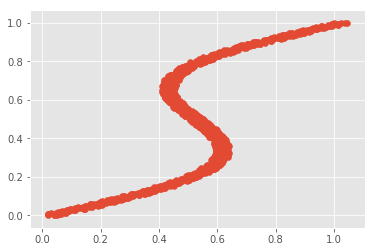

In [47]:
plt.scatter(data.x,data.target)
plt.show()

The following piece is necessary to be able to feed the observed data into `pm.NormalMixture()`.

In [48]:
y_obs = np.repeat(data.x.values.reshape(-1, 1), 3, axis=1).transpose()
y_obs.shape

(3, 1000)

Writing the code is then actually quite straightforward. We borrow the nice `CheckParametersConvergence` from [here](https://docs.pymc.io/notebooks/variational_api_quickstart.html) to plot the convergence later.

In [49]:
from pymc3.variational.callbacks import CheckParametersConvergence

x = data.x.values.reshape(-1, 1)
ones = np.ones_like(x)

with pm.Model() as moe:
    # Model the expert means
    bias_expert_mean = pm.Normal('bias_mean', mu=0, sd=5, shape=(1, 3))
    slope_expert_mean = pm.Normal('slope_mean', mu=0, sd=5, shape=(1, 3))
    means_expert = pm.Deterministic('mu_exp', pm.math.dot(ones, bias_expert_mean) + pm.math.dot(x, slope_expert_mean))
    
    # Model the expert standard deviations
    bias_expert_sd = pm.Normal('bias_sd', mu=0, sd=5, shape=(1, 3))
    slope_expert_sd = pm.Normal('slope_sd', mu=0, sd=5, shape=(1, 3))
    sd_log_expert = pm.math.dot(ones, bias_expert_sd) + pm.math.dot(x, slope_expert_sd)
    sd_expert = pm.Deterministic('sd_exp', pm.math.exp(sd_log_expert) + 0.01)
    
    # Model the mixing weights
    α = pm.Normal('alpha', mu=0, sd=5, shape=(1, 3))
    β = pm.Normal('beta', mu=0, sd=5, shape=(1, 3))
    λ_logit = pm.math.dot(ones, α) + pm.math.dot(x, β)
    λ = pm.Deterministic('lambda', tt.nnet.softmax(λ_logit))
    
    # Model the outcome
    obs = pm.NormalMixture('obs', w=λ, 
                                  mu=means_expert,
                                  sd=sd_expert, observed=data.target.values)

Let's plot the graphical structure:

In [50]:
_ = pm.model_to_graphviz(moe)

> **A2** Fit this model variationally for about 50,000 iterations using the adam optimizer. (`obj_optimizer=pm.adam()`) Plot the ELBO to make sure you have converged. Print summaries and traceplots for the means, $\sigma$s and probabilities.

In [51]:
with moe:
    approx = pm.fit(50000, obj_optimizer=pm.adam(), callbacks=[CheckParametersConvergence()])

Average Loss = -1,602.5: 100%|██████████| 50000/50000 [02:03<00:00, 403.24it/s]
Finished [100%]: Average Loss = -1,602.6


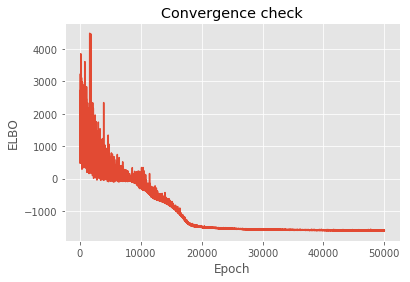

In [52]:
plt.plot(approx.hist)
plt.xlabel("Epoch")
plt.ylabel("ELBO")
plt.title("Convergence check")
plt.show()

We see from the plot above that we have, indeed, converged.

In [53]:
trace = approx.sample(5000)

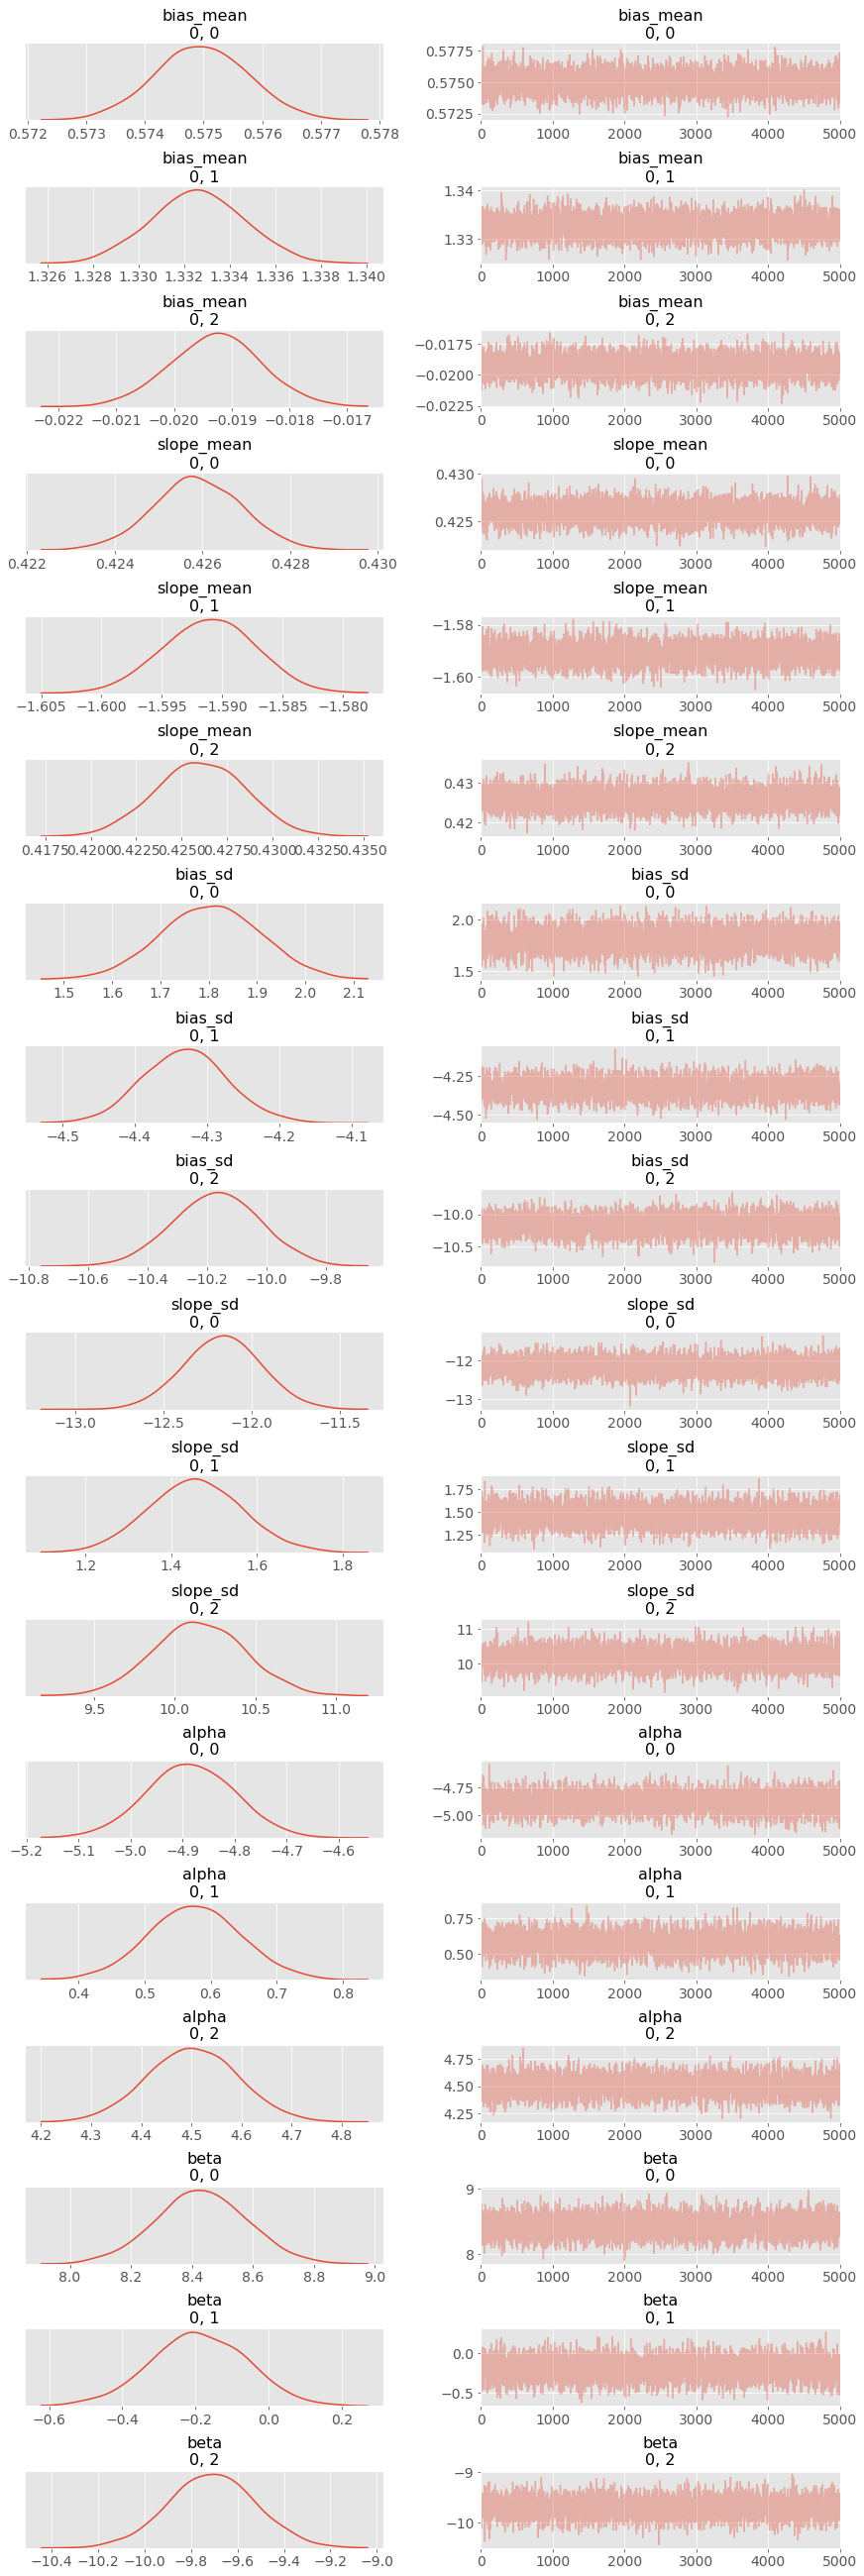

In [54]:
_ = az.plot_trace(trace, var_names=['bias_mean', 'slope_mean', 'bias_sd', 'slope_sd', 'alpha', 'beta'])

In [55]:
pm.summary(trace, varnames=['bias_mean', 'slope_mean', 'bias_sd', 'slope_sd', 'alpha', 'beta'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
bias_mean__0_0,0.574969,0.000797,0.000011,0.573339,0.576490
bias_mean__0_1,1.332619,0.002036,0.000028,1.328698,1.336594
bias_mean__0_2,-0.019274,0.000785,0.000012,-0.020827,-0.017743
slope_mean__0_0,0.425897,0.000997,0.000013,0.423939,0.427849
slope_mean__0_1,-1.591045,0.003830,0.000062,-1.598655,-1.583793
slope_mean__0_2,0.426060,0.002463,0.000035,0.421205,0.430661
bias_sd__0_0,1.804142,0.103492,0.001502,1.606049,2.010175
bias_sd__0_1,-4.329906,0.057498,0.000780,-4.439132,-4.213708
bias_sd__0_2,-10.165536,0.144567,0.002011,-10.434996,-9.873934
slope_sd__0_0,-12.164442,0.214589,0.002766,-12.584116,-11.740537


The `bias_mean` variables make sense: note that they correspond to the value at `x=0`. Looking at the pictures above, we see that it matches.

> **A3** Plot the mean posteriors with standard deviations against x. Also produce a diagram like the one above to show the mean"s with standard deviations showing their uncertainty overlaid on the data.

In [56]:
def plot_fit(pred_mean, pred_sigma, title='', scatter=False):
    for mu, sigma in zip(pred_mean.T, pred_sd.T):
        plt.plot(data.x, mu)
        plt.fill_between(data.x, mu-sigma, mu+sigma, alpha=0.3)
    if scatter:
        plt.scatter(data.x, data.target,s=1.5, alpha=0.5, c='black')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel("x")
    plt.ylabel("target")
    plt.title(title)
    plt.show()

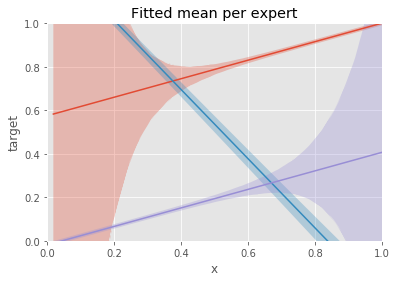

In [57]:
pred_mean = trace['mu_exp'].mean(axis=0)
pred_sd = trace['sd_exp'].mean(axis=0)
plot_fit(pred_mean, pred_sd,title='Fitted mean per expert')

In the plot above, the lines are the **average lines**. The standard deviations are not the uncertainty of the lines, but rater the full uncertainty, including the sampling variance $\sigma_i(x)$ for expert $i$ at position $x$.

In [58]:
def plot_traces(λ,σ,μ):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,8))
    ax1.plot(data.x, λ)
    ax1.set_title(r"Mixture weight $\lambda$")
    ax2.plot(data.x, σ)
    ax2.set_title('$\sigma$')
    ax3.plot(data.x, μ)
    ax3.set_title('$\mu$')
    plt.show()

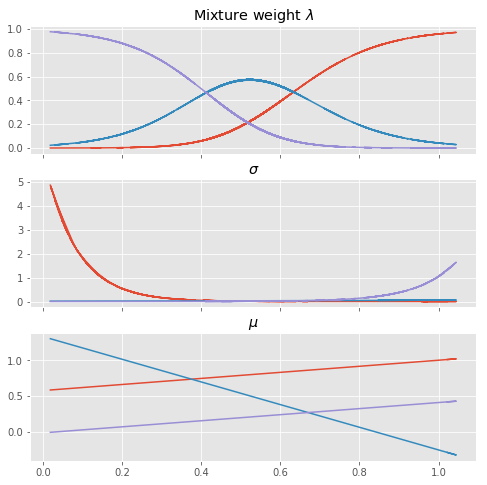

In [59]:
plot_traces(trace['lambda'].mean(axis=0),
            trace['sd_exp'].mean(axis=0),
            trace['mu_exp'].mean(axis=0))

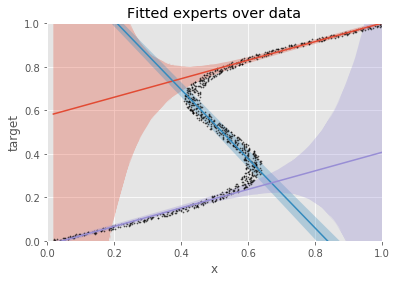

In [60]:
a = trace['bias_mean'].mean(axis=0)[0, :]
b = trace['slope_mean'].mean(axis=0)[0, :]

pred_mean = a + x * b
plot_fit(pred_mean, pred_sd,title='Fitted experts over data', scatter=True)

> **A4** Plot the posterior predictive (mean and variance) as a function of x) for this model (using `sample_ppc` for example). Why does the posterior predictive look nothing like the data?

In [61]:
with moe:
    pp_samples = pm.sample_ppc(trace, 300)

100%|██████████| 300/300 [00:20<00:00, 14.88it/s]


Text(0.5, 1.0, 'Posterior predictive plot')

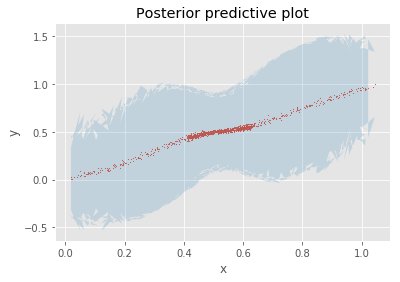

In [62]:
means = pp_samples['obs'].mean(axis=0)
sds = pp_samples['obs'].std(axis=0)

plt.scatter(data.x, means, s=.3)
plt.fill_between(data.x, y1=means-1.96*sds, y2=means+1.96*sds, alpha=.2)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Posterior predictive plot")

The plot makes no sense because we are simply predicting the overall mean for every point, independent of any cluster assignment. From this point of view, however, the plot makes sense. Consider, for example, the very left of the plot, small $x$. There the weight of the "blue" and "red" cluster from the image above, is very small and so the mean has to be close to the cluster with high weight. This mean is zero.

In the middle, where we have several distinct clusters, the average prediction (which is what the ppc does) must lie somewhere at the average of the three clusters. The uncertainty, however, must be high.

> **A5** Make a "correct" posterior predictive diagram by taking into account which "cluster" or "regression line" the data is coming from. To do this you will need to sample using the softmax probabilities. A nice way to do this is "Gumbel softmax sampling". See http://timvieira.github.io/blog/post/2014/07/31/gumbel-max-trick/ for details. Color-code the predictive samples with the gaussian they came from. Superimpose the predictive on the original data. You may want to contrast a prediction from a point estimate at the mean values of the $\mu$ and $\sigma$ traces at a given x (given the picked gaussian) to the "full" posterior predictive obtained from sampling from the entire trace of $\mu$ and $\sigma$ and $\lambda$. The former diagram may look something like this:


We steal the Gumel-softmax (slightly modified) from the link above. For a simple posterior replication, we first sample the cluster assignments.

In [63]:
ind = 0

def gumbel_max_sample(x):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (x + z).argmax(axis=1)


clusters = gumbel_max_sample(np.log(trace['lambda'])[ind, :, :])

Then we calculate the mean and standard deviation and sample from a corresponding normal to obtain a posterior predictive `y` sample.

In [64]:
pred_mean = trace['bias_mean'][ind, 0, clusters] + trace['slope_mean'][ind, 0, clusters] * data.x
pred_sd = np.exp(trace['bias_sd'][ind, 0, clusters] + trace['slope_sd'][ind, 0, clusters] * data.x) + 0.01
y_ppc = np.random.normal(pred_mean, pred_sd)

Finally, we can plot:

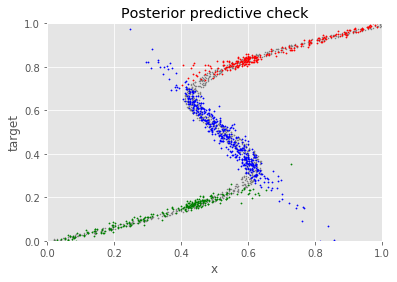

In [65]:
def plot_pred(clusters=clusters, pred=y_ppc, title='Posterior predictive check'):
    fig, ax = plt.subplots()
    ax.scatter(data.x, data.target, c='grey', s=1.0)
    for i, v in enumerate(['red','blue','green']):
        ax.scatter(data.x[clusters==i], pred[clusters==i], c=v, s=1.5)
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("target")
    plt.show()
    
plot_pred()

Let's also do a full posterior by cluster:

(0, 1)

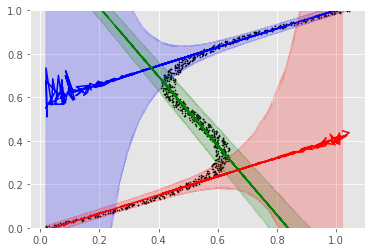

In [66]:
ppc_per_class = np.random.normal(trace['mu_exp'], trace['sd_exp'])

mus = ppc_per_class.mean(axis=0)
errs = np.percentile(ppc_per_class, axis=0, q=[2.5, 97.5])

fig, ax= plt.subplots()

plt.scatter(data.x, data.target, s=1.3, c='black')
plt.plot(data.x, mus[:, 0], c='b')
plt.plot(data.x, mus[:, 1], c='g')
plt.plot(data.x, mus[:, 2], c='r')

plt.fill_between(data.x, errs[0, :, 0], errs[1, :, 0], alpha=.2, color='blue')
plt.fill_between(data.x, errs[0, :, 1], errs[1, :, 1], alpha=.2, color='green')
plt.fill_between(data.x, errs[0, :, 2], errs[1, :, 2], alpha=.2, color='red')
ax.set_ylim(0, 1)

## Part B. Mixture Density Network

A mixture density network (see the enclosed Chapter 5 excerpt from Bishop or https://publications.aston.ac.uk/373/1/NCRG_94_004.pdf) is very closely related to the mixture of experts model. The difference is that we fit the regressions using a neural network where hidden layers are shared amongst the mean, sigma, and mixing probability regressions. (We could have fit 3 separate neural networks in Part A but opted to fit linear regressions for simplicity)

(More explanation [here](https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb). You are welcome to take code from here with attribution.)

You job here is to construct a multi-layer perceptron model with a linear hidden layer with 20 units followed by a `Tanh` activation. After the activation layer, 3 separate linear layers with `n_hidden` inputs and `n_gaussian=3` outputs will complete the network. The probabilities part of the network is then passed through a softmax. The means part is left as is. The sigma part is exponentiated and 0.01 added, as in part A

Thus the structure looks like:

```
input:1 --linear-> n_hidden -> Tanh --linear-->n_gaussians      ...mu
                            --linear-->n_gaussians->softmax     ...lambda
                            --linear-->n_gaussians->exp + 0.01  ...sigma
```

We then need to use a loss function for the last layer of the network. 

Using the mean-squared-error loss is not appropriate as the expected value of samples drawn from the sampling distribution of the network will not reflect the 3-gaussian structure (this is the essence of the difference between A4 and A5 above). Thus we'll use the negative loss likelihood of the gaussian mixture model explicitly.

**B1**: Write the network as a class `MixtureDensityNetwork` which inherits from pytorch `nn.Module`. Implement a constructor which allows at-least the number of hidden layers to be varied. Also implement the `forward` method.

**B2**: Train the network using the Adam or similiar optimizer and gradient descent/SGD. Make sure your loss converges and plot this convergence.

**B3**: Plot the MLE parameters against x. Make a plot similar to A3 above where you overlay the "means" of the gaussians against the data.  Plot traces of the mu/sigma/lambda as an aid in debugging.

**B4**: Sample from the sampling distributions at the estimated point values of $\mu$ and $\sigma$ (given cluster) to make a plot similar to A5 above

**To think but not to hand in** What are the differences between a mixture density network and the mixture of experts. How do these differences translate to feature space? What would happen if we took the shared hidden layer nonlinearity (Tanh) out?

> **B1**: Write the network as a class `MixtureDensityNetwork` which inherits from pytorch `nn.Module`. Implement a constructor which allows at-least the number of hidden layers to be varied. Also implement the `forward` method.

In [67]:
import torch
import torch.nn as nn 
from torch.autograd import Variable


class MixtureDensityNetwork(nn.Module):
    """
    input:1 --linear-> n_hidden -> Tanh --linear-->n_gaussians              ...mu
                                        --linear-->n_gaussians->softmax     ...lambda
                                        --linear-->n_gaussians->exp + 0.01  ...sigma
    """
    def __init__(self, n_hidden, n_gaussians):
        super().__init__()
        self.linear_hidden = nn.Sequential(nn.Linear(1, n_hidden),nn.Tanh())
        self.μ = nn.Linear(n_hidden, n_gaussians)
        self.λ = nn.Linear(n_hidden, n_gaussians)
        self.σ = nn.Linear(n_hidden, n_gaussians)  

    def forward(self, x):
        linear_hidden = self.linear_hidden(x)
        μ = self.μ(linear_hidden)
        λ = nn.functional.softmax(self.λ(linear_hidden), dim=-1)
        σ = torch.exp(self.σ(linear_hidden)) + 0.01
        return  λ, σ, μ

>**B2**: Train the network using the Adam or similiar optimizer and gradient descent/SGD. Make sure your loss converges and plot this convergence.

The following code was adapted from https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb

In [68]:
oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi) # normalization factor for Gaussians

def gaussian_distribution(y, mu, sigma):
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

def loss_fn(pi, sigma, mu, y):
    result = gaussian_distribution(y, mu, sigma) * pi
    result = torch.sum(result, dim=1)
    result = -torch.log(result)
    return torch.mean(result)


network = MixtureDensityNetwork(n_hidden=20, n_gaussians=3)

optimizer = torch.optim.Adam(network.parameters())


n_input = 1
n_hidden = 20
n_output = 1 
n_samples = data.shape[0]

x_tensor = torch.from_numpy(np.float32(data.x).reshape(n_samples, n_input))
y_tensor = torch.from_numpy(np.float32(data.target).reshape(n_samples, n_input))

x_variable = Variable(x_tensor)
y_variable = Variable(y_tensor, requires_grad=False)


def train():
    losses = []
    for epoch in range(10000):
        lambda_variable, sigma_variable, mu_variable = network(x_variable)
        loss = loss_fn(lambda_variable, sigma_variable, mu_variable, y_variable)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss)
        
        if epoch % 500 == 0:
            print(epoch, loss.item())
    return losses
losses = train()

0 1.2622382640838623
500 -0.11891381442546844
1000 -0.12775462865829468
1500 -0.9268799424171448
2000 -1.8670729398727417
2500 -1.8904093503952026
3000 -1.9028892517089844
3500 -1.913802146911621
4000 -1.9243597984313965
4500 -1.9361358880996704
5000 -1.9483060836791992
5500 -1.960912823677063
6000 -1.9736536741256714
6500 -1.9853630065917969
7000 -1.9940133094787598
7500 -2.004549741744995
8000 -2.011606454849243
8500 -2.0159518718719482
9000 -2.022270441055298
9500 -2.026031494140625


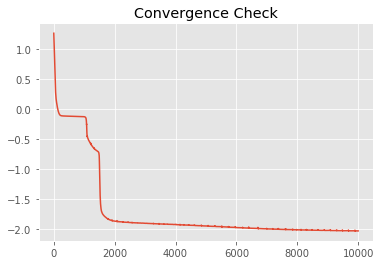

In [69]:
plt.title('Convergence Check')
plt.plot(losses)
plt.show()

We can see that convergence around 2000 epochs. We also see this step that was observed in the ELBO plot of part 1. Most likely this is a local minima that we are jumping out of.

>**B3**: Plot the MLE parameters against x. Make a plot similar to A3 above where you overlay the "means" of the gaussians against the data.  Plot traces of the mu/sigma/lambda as an aid in debugging.

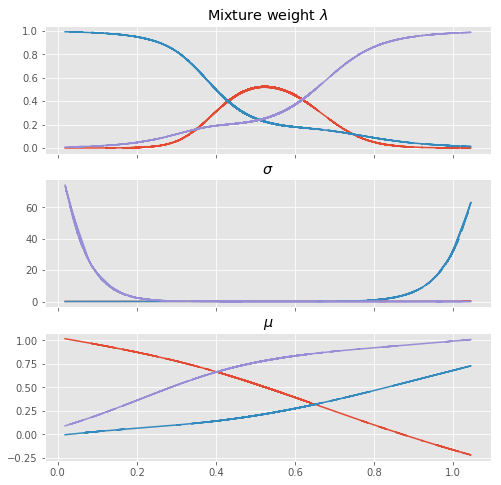

In [70]:
lambda_variable, sigma_variable, mu_variable = network(x_variable)

lambda_data = lambda_variable.data.numpy()
sigma_data = sigma_variable.data.numpy()
mu_data = mu_variable.data.numpy()

plot_traces(lambda_data, sigma_data, mu_data)

The mixture weights are as expected and similar to what was observed in part A. Basically we see a symmetric distribution for the three clusters that is dependent on the data. We can see quite clearly where the probability of the middle cluster arises inversely to the other clusters.

As for the variance, we see a lopsided variance with more uncertainty regarding the bottom cluster. Ideally we would expect a sort of bowl shape for the top and bottom clusters, however this is likely just sampling variance as this was observed in other runs.

We can see that the fitted mean values are closer to the data as the curvature is modelled better. This is in contrast to the straight lines observered in part A. 



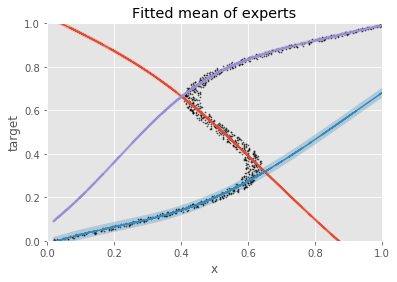

In [71]:
plot_fit(mu_data, sigma_data, title='Fitted mean of experts', scatter=True)

>**B4**: Sample from the sampling distributions at the estimated point values of $\mu$ and $\sigma$ (given cluster) to make a plot similar to A5 above

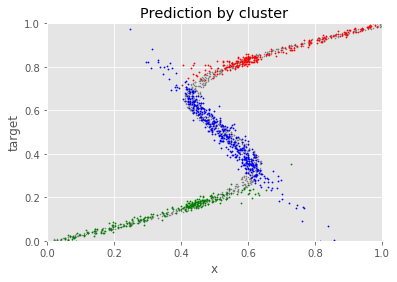

In [72]:
clusters = gumbel_max_sample(np.log(lambda_data))
indices = (np.arange(n_samples), clusters)
y_ppc = np.random.randn(n_samples) * sigma_data[indices] + mu_data[indices]

plot_pred(title='Prediction by cluster')

The plot is much like before in part A, but its slightly improved at the intersection of clusters.

## Part C Variational Mixture Density Network

We want to implement the Mixture Density Metwork model that we constructed in Part B  directly in pymc3 and use variational inference to sample from it. We  may need more iterations in order to get convergence as this model will likely not converge as fast as the pytorch equivalent.

**C1**: Write out the equivalent pymc3 version of the MDN and generate posterior samples with ADVI.

**C2**: Sample from the posterior predictive and produce a diagram like B4 and A5 for this model. Plot traces of the mu/sigma/lambda as an aid in debugging your sampler.

**C3**: Plot the "mean" regression curves (similar to B3 and A3). Do the "mean" regression curves in this model look the same from those in Part B?  If they differ why so?

> **C1**: Write out the equivalent pymc3 version of the MDN and generate posterior samples with ADVI.

This is straightforward, we only add a hidden layer to the code from A:

In [73]:
from pymc3.variational.callbacks import CheckParametersConvergence

x = data.x.values.reshape(-1, 1)
ones = np.ones_like(x)
n_hidden = 20

ones_big = np.zeros((x.shape[0], n_hidden))

with pm.Model() as mdn:
    # Hidden layer
    hidden_bias = pm.Normal('hidden_bias', mu=0, sd=1, shape=(1, n_hidden))
    hidden_weights = pm.Normal('hidden_weights', mu=0, sd=1, shape=(1, n_hidden))
    activation = pm.math.tanh(pm.math.dot(ones, hidden_bias) + pm.math.dot(x, hidden_weights))
    
    # Model the expert means
    bias_expert_mean = pm.Normal('bias_mean', mu=0, sd=5, shape=(n_hidden, 3))
    slope_expert_mean = pm.Normal('slope_mean', mu=0, sd=5, shape=(n_hidden, 3))
    means_expert = pm.Deterministic('mu_exp', pm.math.dot(ones_big, bias_expert_mean) + pm.math.dot(activation, slope_expert_mean))
    
    # Model the expert standard deviations
    bias_expert_sd = pm.Normal('bias_sd', mu=0, sd=5, shape=(n_hidden, 3))
    slope_expert_sd = pm.Normal('slope_sd', mu=0, sd=5, shape=(n_hidden, 3))
    sd_log_expert = pm.math.dot(ones_big, bias_expert_sd) + pm.math.dot(activation, slope_expert_sd)
    sd_expert = pm.Deterministic('sd_exp', pm.math.exp(sd_log_expert) + 0.01)
    
    # Model the mixing weights
    α = pm.Normal('alpha', mu=0, sd=5, shape=(n_hidden, 3))
    β = pm.Normal('beta', mu=0, sd=5, shape=(n_hidden, 3))
    λ_logit = pm.math.dot(ones_big, α) + pm.math.dot(activation, β)
    λ = pm.Deterministic('lambda', tt.nnet.softmax(λ_logit))
    
    # Model the outcome
    obs = pm.NormalMixture('obs', w=λ, 
                                  mu=means_expert,
                                  sd=sd_expert, observed=data.target.values)



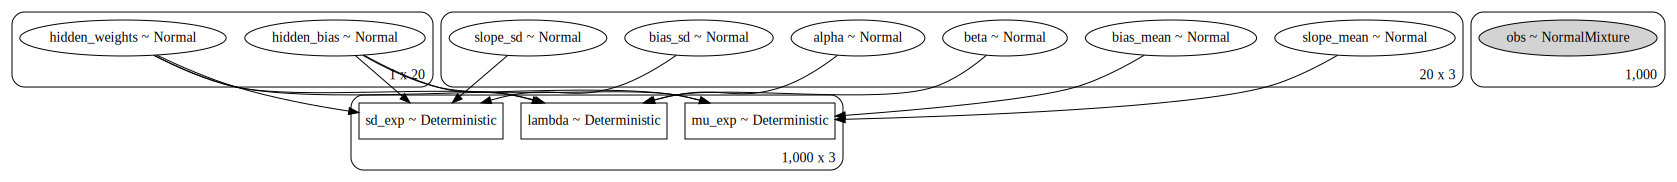

In [74]:
pm.model_to_graphviz(mdn)

In [75]:
with mdn:
    approx = pm.fit(100000, obj_optimizer=pm.adam(), callbacks=[CheckParametersConvergence()])

Average Loss = -1,393.7: 100%|██████████| 100000/100000 [05:45<00:00, 289.11it/s]
Finished [100%]: Average Loss = -1,393.6


Text(0.5, 1.0, 'Convergence check')

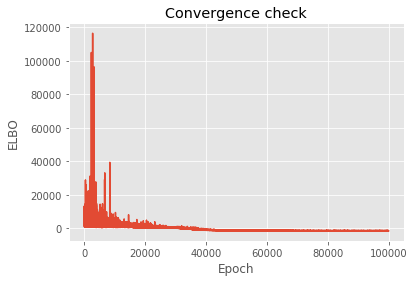

In [76]:
plt.plot(approx.hist)
plt.xlabel("Epoch")
plt.ylabel("ELBO")
plt.title("Convergence check")

> **C2**: Sample from the posterior predictive and produce a diagram like B4 and A5 for this model. Plot traces of the mu/sigma/lambda as an aid in debugging your sampler.

In [77]:
trace = approx.sample(5000)

Next, we make a posterior predictive check based on a single sample. This is pretty similar to what was observed for the network model, however it looks like we are doing slightly worse on modelling the middle cluster.

In [78]:
n_data = data.shape[0]
ind = 0
clusters = gumbel_max_sample(np.log(trace['lambda'])[ind, :, :])

act = np.tanh(trace['hidden_bias'][ind, 0, :].reshape(1, -1) + x.dot(trace['hidden_weights'][ind, :, :]))
pred_mean = ones_big.dot(trace['bias_mean'][ind, :, :]) + act.dot(trace['slope_mean'][ind, :, :])
pred_sd = np.exp(ones_big.dot(trace['bias_mean'][ind, :, :]) + act.dot(trace['slope_sd'][ind, :, :])) + 0.01
y_sim = np.random.normal(pred_mean, pred_sd)
y_ppc = np.empty(n_data)

for i in range(n_data):
    y_ppc[i] = y_sim[i, clusters[i]]

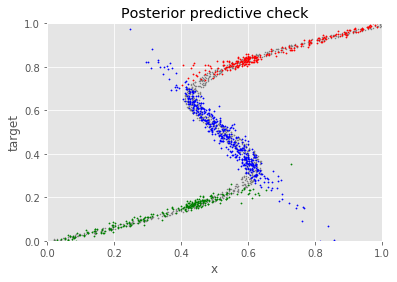

In [79]:
plot_pred(title="Posterior predictive check")

In [80]:
trace.varnames

['hidden_bias',
 'hidden_weights',
 'bias_mean',
 'slope_mean',
 'bias_sd',
 'slope_sd',
 'alpha',
 'beta',
 'mu_exp',
 'sd_exp',
 'lambda']

We randomly plot the traces for a couple of data points.

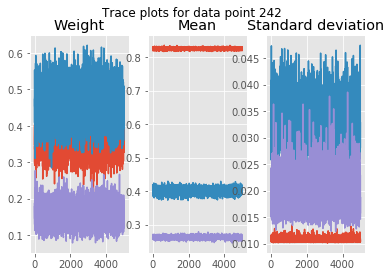

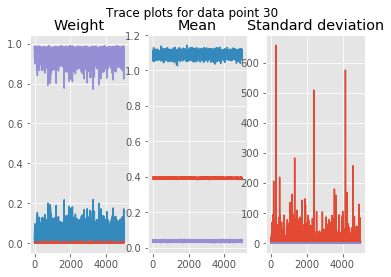

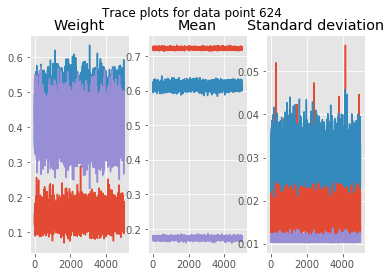

In [81]:
for _ in range(3):
    ind = np.random.randint(1000)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle("Trace plots for data point {}".format(ind))
    ax1.plot(trace['lambda'][:, ind, :])
    ax1.set_title(r"Weight")
    
    ax2.plot(trace['mu_exp'][:, ind, :])
    ax2.set_title("Mean")
    
    ax3.plot(trace['sd_exp'][:, ind, :])
    ax3.set_title("Standard deviation")

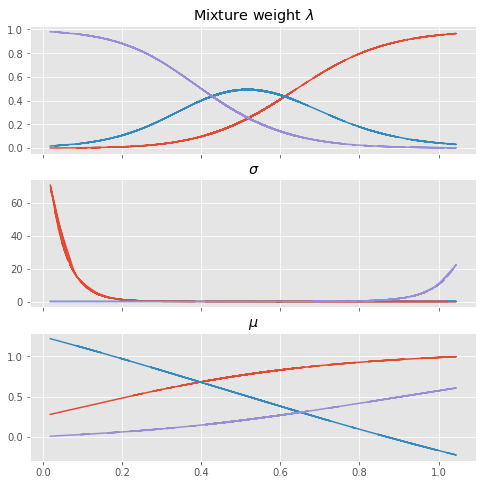

In [82]:
plot_traces(trace['lambda'].mean(axis=0),
            trace['sd_exp'].mean(axis=0),
            trace['mu_exp'].mean(axis=0))

Trace plots looks good (correlation can't occur anyway).

> **C3**: Plot the "mean" regression curves (similar to B3 and A3). Do the "mean" regression curves in this model look the same from those in Part B?  If they differ why so?

In [83]:
pred_mean = trace['mu_exp'].mean(axis=0)
pred_sd = trace['sd_exp'].mean(axis=0)

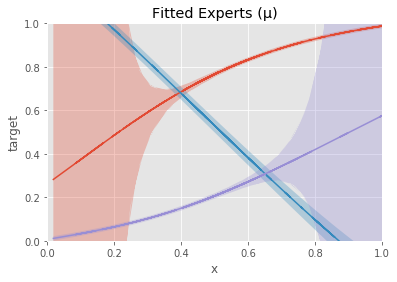

In [84]:
plot_fit(pred_mean, pred_sd, title='Fitted Experts (μ)')

The regression curves look similar to the curves in part B. The main difference is that the middle curve is more of a line which may explain the slightly worse posterior predictive samples for the middle cluster.

The curvature is, by and large, small so that the lines look very similar to part A. 

## Q3:  Exploring Temperature in Sampling and Optimiztion

At various times in class we've discussed in very vague terms the relation between "temperature" and sampling from or finding optima of distributions.  Promises would invariably be made that at some later point we'd discuss the concept of temperature and sampling/optima finding in more detail.  Let's take this problem as an opportunity to keep our promise.

Let's start by considering the function $f(x, y)$ defined in the following code cell. $f(x, y)$ is a mixture of three well separated Gaussian probability densities.

In [85]:
make_cov = lambda  theta: np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

theta_vec = (5.847707364986893, 5.696776968254305, 1.908095937315489)
theta1, theta2, theta3 = theta_vec

# define gaussian mixture 1 
cov1 = make_cov(theta1)
sigma1 = np.array([[2, 0],[0, 1]])
mvn1 = scipy.stats.multivariate_normal([12, 7], cov=cov1@sigma1@cov1.T)

# define gaussian mixture 2
cov2 = make_cov(theta2)
sigma2 = np.array([[1, 0],[0, 3]])
mvn2 = scipy.stats.multivariate_normal([-1, 6], cov=cov2@sigma2@cov2.T)

cov3 = make_cov(theta3)
sigma3 = np.array([[.4, 0],[0, 1.3]])
mvn3 = scipy.stats.multivariate_normal([3,-2], cov=cov3@sigma3@cov3.T)

f = lambda xvec: mvn1.pdf(xvec) + mvn2.pdf(xvec) + .5*mvn3.pdf(xvec)

p = lambda x, y: f([x,y])

## Part A Visualization and Metropolis

**A1**. Visualize $p(x, y)$ with a contour or surface plot.  Make sure to title your plot and label all axes.  What do you notice about $p(x, y)$?  Do you think it will be an easy function to sample?

**A2**. Generate 20000 samples from $p(x, y)$ using the Metropolis algorithm.  Pick individual gaussian proposals in $x$ and $y$ with $\sigma=1$, initial values, burnin parameters, and thinning parameter.  Plot traceplots of the $x$ and $y$ marginals as well as autocorrelation plots.  Plot a pathplot of your samples.  Based on your visualizations, has your Metropolis sampler generated an appropriate representation of the distribution $p(x, y)$?

A pathplot is just your samples trace overlaid on your pdf, so that you can see how the sampler traversed. It looks something like this:

![](images/pathplot.png)

>**A1**. Visualize $p(x, y)$ with a contour or surface plot.  Make sure to title your plot and label all axes.  What do you notice about $p(x, y)$?  Do you think it will be an easy function to sample?

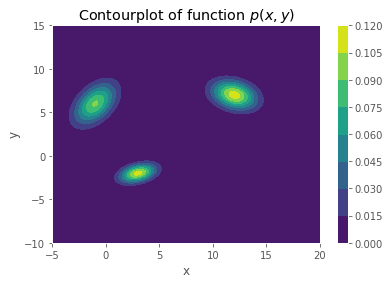

In [86]:
x_min, x_max, y_min, y_max = -5, 20, -10, 15
n = 200

xs = np.linspace(x_min, x_max, num=n)
ys = np.linspace(y_min, y_max, num=n)
XX, YY = np.meshgrid(xs, ys)

ZZ = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        ZZ[i, j] = p(XX[i, j], YY[i, j])

plt.contourf(XX, YY, ZZ)
plt.xlabel("x")
plt.ylabel("y")
plt.title(r"Contourplot of function $p(x, y)$")
plt.colorbar()
plt.show()

We see that $p(x, y)$ is **multimodal**, i.e. it has several peaks. The valleys between the peaks are relatively low. Furthermore, there is some **correlation**.

The deep valleys between the peaks mean that Markov Chain Monte Carlo will be difficult. We have to propose **very large jumps** to go from one peak to another, which leads to low acceptance rates in general. 

Also the correlation (though it is not too big) will make a Metropolis sampler inefficient.

> **A2**. Generate 20000 samples from $p(x, y)$ using the Metropolis algorithm.  Pick individual gaussian proposals in $x$ and $y$ with $\sigma=1$, initial values, burnin parameters, and thinning parameter.  Plot traceplots of the $x$ and $y$ marginals as well as autocorrelation plots.  Plot a pathplot of your samples.  Based on your visualizations, has your Metropolis sampler generated an appropriate representation of the distribution $p(x, y)$?

In [87]:
# Proposal function
np.random.seed(1)
q_draw = lambda x: np.random.normal(loc=x, scale=1, size=2)
x_init = np.random.normal(loc=(0, 0), scale=5, size=2)
n_samples = 20000
burnin = 10000
thinning = 5
n_total = n_samples * thinning + burnin


def metropolis(p, qdraw, nsamp, xinit):
    samples=np.empty((nsamp, 2))
    x_prev = xinit
    for i in range(nsamp):
        x_star = qdraw(x_prev)
        p_star = p(x_star[0], x_star[1])
        p_prev = p(x_prev[0], x_prev[1])
        pdfratio = p_star/p_prev
        if np.random.uniform() < min(1, pdfratio):
            samples[i, :] = x_star
            x_prev = x_star
        else:#we always get a sample
            samples[i, :]= x_prev
            
    return samples

samples = metropolis(p, q_draw, n_total, x_init)[burnin::thinning]

Text(0.5, 1.0, 'Traceplot for y')

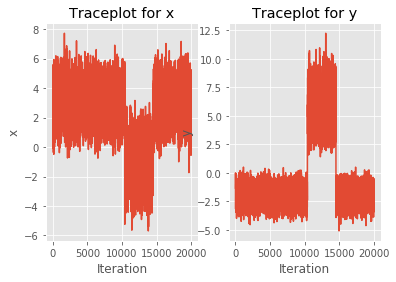

In [88]:
plt.subplot(1, 2, 1)
plt.plot(samples[:, 0])
plt.xlabel("Iteration")
plt.ylabel("x")
plt.title("Traceplot for x")

plt.subplot(1, 2, 2)
plt.plot(samples[:, 1])
plt.xlabel("Iteration")
plt.ylabel("y")
plt.title("Traceplot for y")

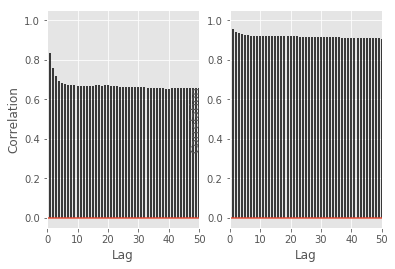

In [89]:
def corrplot(trace, maxlags=50):
    plt.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    plt.xlim([0, maxlags])
    plt.xlabel("Lag")
    plt.ylabel("Correlation")

plt.subplot(1, 2, 1)
corrplot(samples[:, 0], 50)

plt.subplot(1, 2, 2)
corrplot(samples[:, 1], 50)

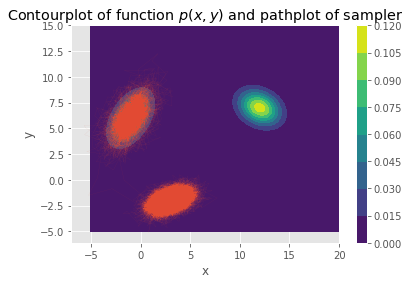

In [90]:
x_min, x_max, y_min, y_max = -5, 20, -5, 15
n = 200

xs = np.linspace(x_min, x_max, num=n)
ys = np.linspace(y_min, y_max, num=n)
XX, YY = np.meshgrid(xs, ys)

ZZ = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        ZZ[i, j] = p(XX[i, j], YY[i, j])

plt.contourf(XX, YY, ZZ)
plt.xlabel("x")
plt.ylabel("y")
plt.title(r"Contourplot of function $p(x, y)$ and pathplot of sampler")
plt.colorbar()

plt.plot(samples[:, 0], samples[:, 1], linewidth=.05, linestyle='-.')


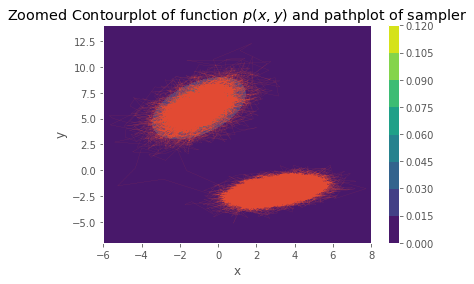

In [91]:
x_min, x_max, y_min, y_max = -6, 8, -7, 14
n = 200

xs = np.linspace(x_min, x_max, num=n)
ys = np.linspace(y_min, y_max, num=n)
XX, YY = np.meshgrid(xs, ys)

ZZ = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        ZZ[i, j] = p(XX[i, j], YY[i, j])

plt.contourf(XX, YY, ZZ)
plt.xlabel("x")
plt.ylabel("y")
plt.title(r"Zoomed Contourplot of function $p(x, y)$ and pathplot of sampler")
plt.colorbar()

plt.plot(samples[:, 0], samples[:, 1], linewidth=.1, linestyle='-.')
plt.show()

From the pathplot it's obvious that the sampler **has not converged**: it was not able, as anticipated, to move between the peaks often. In particular, it did not reach the third peak at all. Futhermore, the autocorrelation is extremely high (interestingly, this is more pronounced because we were able to change between peaks; had we stayed near a single peak, the autocorrelation would start vanishing after more lags).

## Part B: Changing pdfs using temperature

Given a function $p(x)$ we can rewrite that function in following way:

$$p(x) = e^{-(-\log(p(x))}$$

So if define the energy density for a function as $E(x)\equiv-\log{p(x)}$

We can now aim to sample from the function parameratized by a Temperature $T$.

$$p(x\vert T) = e^{-\frac{1}{T} E(x)} = p(x)^{\frac{1}{T}}$$

If we set T=1 we're sampling from our original function $p(x)$. 

**B1** In line with A1, visualize modified pdfs (dont worry about normalization) by setting the temperatures to $T=10$ and $T=0.1$. 

**B2**. Modify your Metropolis algorithm above to take a temperature parameter `T` as well as to keep track of the number of rejected proposals.  Generate 20000 samples from $p(x, y)$ at for each of the following temperatures: {0.1, 1, 3, 7, 10}. Construct  histograms of the marginals, traceplots, autocorrelation plots, and a pathplot for your samples at each temperature.  What happens to the number of rejections as temperature increases? In the limits $T \rightarrow 0$ and $T \rightarrow \infty$ what do you think your samplers will do?

**B3**. Approximate the $f(X)$ by the appropriate mixture of Gaussians as a way of generating samples from $f(X)$ to compare with other sampling methods.  Use scipy.stats.multivariate_normal to generate 20000 samples.  How do the histograms compare with the histograms for the samples from $f(X)$ at each temperature.  At what temperature do the samples best represent the function? 

> **B1** In line with A1, visualize modified pdfs (dont worry about normalization) by setting the temperatures to $T=10$ and $T=0.1$. 

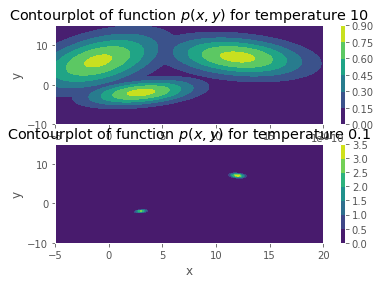

In [92]:
Ts = [10, 0.1]

for i, T in enumerate(Ts):
    plt.subplot(2, 1, i+1)

    x_min, x_max, y_min, y_max = -5, 20, -10, 15
    n = 200

    xs = np.linspace(x_min, x_max, num=n)
    ys = np.linspace(y_min, y_max, num=n)
    XX, YY = np.meshgrid(xs, ys)

    ZZ = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            ZZ[i, j] = p(XX[i, j], YY[i, j]) ** (1/T)

    plt.contourf(XX, YY, ZZ)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(r"Contourplot of function $p(x, y)$ for temperature {}".format(T))
    plt.colorbar()

We see that for high temperature, it is easier for our MCMC particle to move. This fits well with the physical analogy. Similarly, for lower temperatures it is even more impossible to switch between peaks.

> **B2**. Modify your Metropolis algorithm above to take a temperature parameter `T` as well as to keep track of the number of rejected proposals.  Generate 20000 samples from $p(x, y)$ at for each of the following temperatures: {0.1, 1, 3, 7, 10}. Construct  histograms of the marginals, traceplots, autocorrelation plots, and a pathplot for your samples at each temperature.  What happens to the number of rejections as temperature increases? In the limits $T \rightarrow 0$ and $T \rightarrow \infty$ what do you think your samplers will do?

In [93]:
# Proposal function
q_draw = lambda x: np.random.normal(loc=x, scale=1, size=2)
x_init = np.random.normal(loc=(0, 0), scale=5, size=2)
n_samples = 20000
burnin = 10000
thinning = 5
n_total = n_samples * thinning + burnin

Ts = [0.1, 1, 3, 7, 10]


def metropolis_T(p, qdraw, nsamp, xinit, T):
    """
    Metropolis sampler with temperature
    
    :param p: Probability distribution to sample from
    :param qdraw: Proposla sampler
    :param nsamp: Number of samples
    :param xinit: Initial point for sampler
    :param T: temperature
    """
    samples=np.empty((nsamp, 2))
    x_prev = xinit
    p_T = lambda x, y: p(x, y) ** (1 / T)
    accepted = 0
    for i in range(nsamp):
        x_star = qdraw(x_prev)
        p_star = p_T(x_star[0], x_star[1])
        p_prev = p_T(x_prev[0], x_prev[1])
        pdfratio = p_star/p_prev
        if np.random.uniform() < min(1, pdfratio):
            samples[i, :] = x_star
            x_prev = x_star
            accepted += 1
        else:#we always get a sample
            samples[i, :]= x_prev
            
    return samples, accepted

all_results = {}

for T in Ts:
    all_results[T] = metropolis_T(p, q_draw, n_total, x_init, T)

/home/karma/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


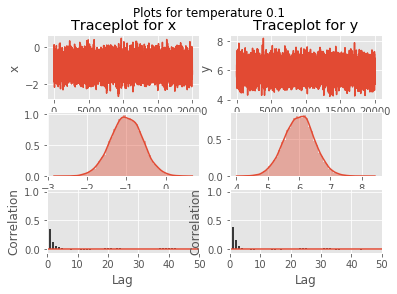

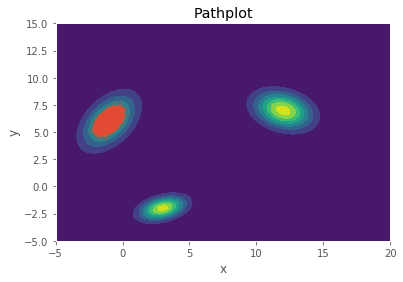

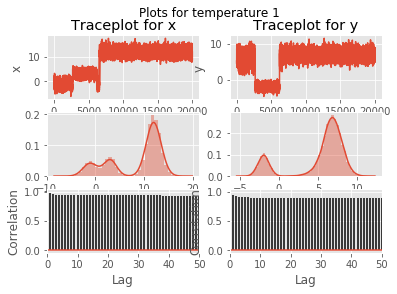

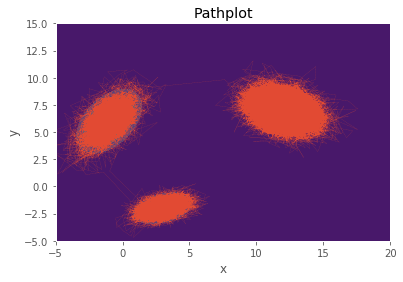

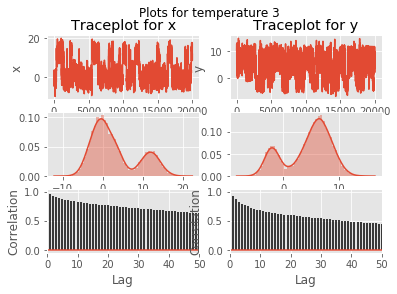

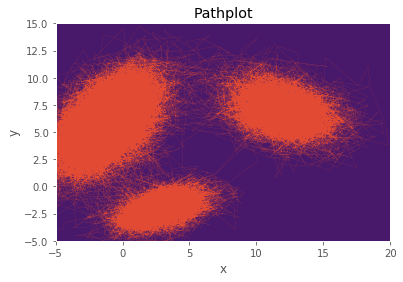

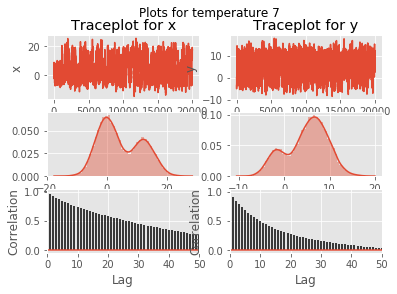

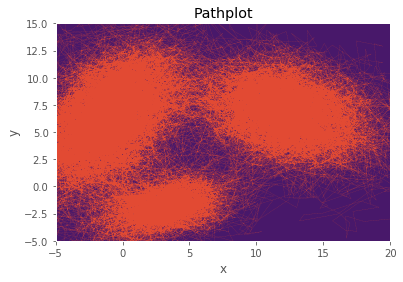

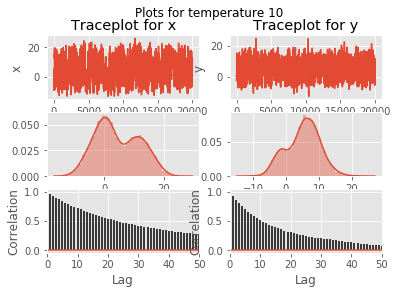

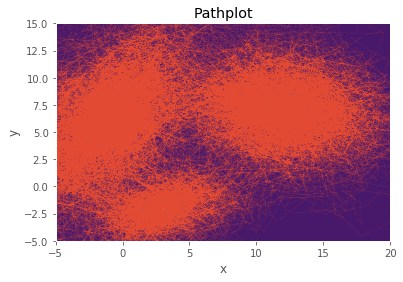

In [94]:
def plot_trace(trace, T):
    """
    Diagnostic and summary plot of trace
    """
    plt.figure()
    
    plt.suptitle("Plots for temperature {}".format(T))
    plt.subplot(3, 2, 1)
    plt.plot(trace[burnin::thinning, 0])
    plt.xlabel("Iteration")
    plt.ylabel("x")
    plt.title("Traceplot for x")

    plt.subplot(3, 2, 2)
    plt.plot(trace[burnin::thinning, 1])
    plt.xlabel("Iteration")
    plt.ylabel("y")
    plt.title("Traceplot for y")
    
    plt.subplot(3, 2, 3)
    sns.distplot(trace[burnin::thinning, 0], axlabel='x')
    
    plt.subplot(3, 2, 4)
    sns.distplot(trace[burnin::thinning, 1], axlabel='y')
    
    plt.subplot(3, 2, 5)
    corrplot(trace[burnin::thinning, 0])
    
    plt.subplot(3, 2, 6)
    corrplot(trace[burnin::thinning, 1])
    
    fig, (ax) = plt.subplots(nrows=1, ncols=1)
    x_min, x_max, y_min, y_max = -5, 20, -5, 15
    n = 200

    xs = np.linspace(x_min, x_max, num=n)
    ys = np.linspace(y_min, y_max, num=n)
    XX, YY = np.meshgrid(xs, ys)

    ZZ = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            ZZ[i, j] = p(XX[i, j], YY[i, j])

    ax.contourf(XX, YY, ZZ)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(r"Pathplot")
    ax.set_xlim((-5, 20))
    ax.set_ylim((-5, 15))

    ax.plot(trace[burnin::thinning, 0], trace[burnin::thinning, 1], linewidth=.15, linestyle='-.')

    
for T in Ts:
    plot_trace(all_results[T][0], T)

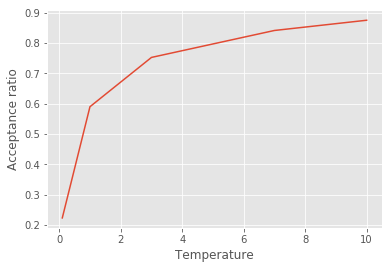

In [95]:
plt.plot(Ts, [all_results[T][1] / all_results[T][0].shape[0] for T in Ts])
plt.xlabel("Temperature")
plt.ylabel("Acceptance ratio")
plt.show()

We expect the system to freeze when the Temperature goes to zero. Freezing means that the MC particle does not move anymore which corresponds to an acceptance ratio of 0. This means that the particle will move to a local maximum.

Conversely, we expect that the acceptance ratio will converge to one as the temperature increases towards infinity. The reason is that the relative energy difference play almost no role.

> **B3**. Approximate the $f(X)$ by the appropriate mixture of Gaussians as a way of generating samples from $f(X)$ to compare with other sampling methods.  Use scipy.stats.multivariate_normal to generate 20000 samples.  How do the histograms compare with the histograms for the samples from $f(X)$ at each temperature.  At what temperature do the samples best represent the function? 

In [96]:
make_cov = lambda  theta: np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

theta_vec = (5.847707364986893, 5.696776968254305, 1.908095937315489)
theta1, theta2, theta3 = theta_vec

# define gaussian mixture 1 
cov1 = make_cov(theta1)
sigma1 = np.array([[2, 0],[0, 1]])
mvn1 = scipy.stats.multivariate_normal([12, 7], cov=cov1@sigma1@cov1.T)

# define gaussian mixture 2
cov2 = make_cov(theta2)
sigma2 = np.array([[1, 0],[0, 3]])
mvn2 = scipy.stats.multivariate_normal([-1, 6], cov=cov2@sigma2@cov2.T)

cov3 = make_cov(theta3)
sigma3 = np.array([[.4, 0],[0, 1.3]])
mvn3 = scipy.stats.multivariate_normal([3,-2], cov=cov3@sigma3@cov3.T)

f = lambda xvec: mvn1.pdf(xvec) + mvn2.pdf(xvec) + .5*mvn3.pdf(xvec)

p = lambda x, y: f([x,y])

In [97]:
from scipy.stats import multivariate_normal
covs = [cov@sigma@cov.T for (cov, sigma) in zip([cov1, cov2, cov3], [sigma1, sigma2, sigma3])]
mus = [(12, 7), (-1, 6), (3, -2)]

In [98]:
def sample_mixture(n_samples):
    """
    Sample from the mixture of Gaussians.
    
    :param n_samples: number of samples to take
    """
    # Weights of mixture model
    weights = np.array((1.0, 1.0, 0.5))
    weights /= weights.sum()
    
    # Initialize results
    results = np.empty((n_samples, 2))
    
    # Sample clusters
    clusters = np.random.choice([0, 1, 2], p=weights, size=n_samples, replace=True)
    
    for i, ind in enumerate(clusters):
        results[i, :] = multivariate_normal.rvs(mean=mus[ind], cov=covs[ind])

    return results

foo = sample_mixture(20000)

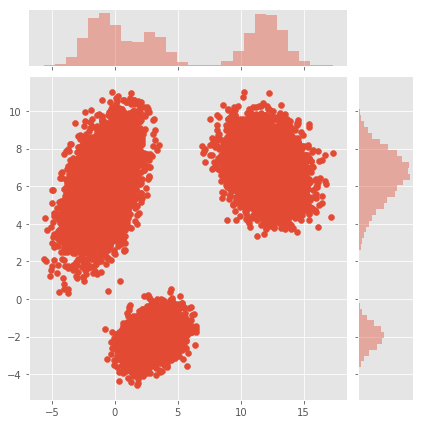

In [99]:
_ = sns.jointplot(foo[:, 0], foo[:, 1])

If we compare with the plots above, the MCMC never fits perfectly. There are always discrepancies recognizable, in particular for the marginals in the x-direction.

The best fit comes from $T=3$: We get good relative heights between the peaks. $T=7$ does not look too bad either, but the particle appears to spend too much time away from the centers.

## Part C: Parallel Tempering

Now that we've seen some of the pproperties of sampling at higher temperatures, let's explore a way to incorporate the improved exploration of the *entire pdf* from sampling at higher temperatures while still getting samples that match our distribution.  We'll use a technique called *parallel tempering*.  

The general idea of parallel tempering is to simulate $N$ replicas of the original system of interest (in our case, a single Metropolis Hastings chain), each replica at a different temperature. The temperature of a Metropolis Hastings Markov Chain defines how likely it is to sample from a low-density part of the target distribution. The high temperature systems are generally able to sample large volumes of parameter space, whereas low temperature systems, while having precise sampling in a local region of parameter space, may become trapped around local energy minima/probability maxima. Parallel tempering achieves good sampling by allowing the chains at different temperatures to exchange complete configurations. Thus, the inclusion of higher temperature chains ensures that the lower temperature chains can access *all* the low-temperature regions of phase space: the higher temperatures help these chains make the jump-over.

Darren Wilkinson's blog post has a [good description](https://darrenjw.wordpress.com/2013/09/29/parallel-tempering-and-metropolis-coupled-mcmc/) of whats going on.

Here is the idea that you must implement.

There are $N$ replicas each at different temperatures $T_i$ that produce $n$ samples each before possibly swapping states.

We simplify matters by only swapping states at adjacent temperatures.  The probability of swapping any two instances of the replicas is given by

$$A = min\left(1, \frac{p_k(x_{k+1})p_{k+1}(x_k)}{p_k(x_k) p_{k+1}(x_{k+1})}\right)$$

One of the $T_i$'s in our set will always be 1 and this is the only replica that we use as output of the Parallel tempering algorithm.

An algorithm for Parallel Tempering is as follows:

1. Initialize the parameters $\{(x_{init}, y_{init})_i\}, \{T_i\}, L$ where 
    * $L$ is the number of iterations between temperature swap proposals.
    * $\{T_i\}$ is a list of temperatures.  You'll run one chain at each temperature.
    * $\{(x_{init}, y_{init})_i\}$ is a list of starting points, one for each chain 
2. For each chain (one per temperature) use the simple Metropolis code you wrote earlier. Perform $L$ transitions on each chain.
3. Set the $\{(x_{init}, y_{init})_i\}$ for the next Metropolis run on each chain to the last sample for each chain i.
4. Randomly choose 2 chains at adjacent temperatures.
    1. Use the above formula to calculate the Acceptance probability $A$.
    2. With probability $A$, swap the positions between the 2 chains (that is swap the $x$s of the two chains, and separately swap the $y$s of the chains .
5. Go back to 2 above, and start the next L-step epoch 
6. Continue until you finish $Num. Samples//L$ epochs.


**C1**. Explain why swapping states with the given acceptance probability is in keeping with detailed balance. The linked blog post might help.

**C2**. Create a parallel tempering sampler that uses 5 chains at  the temperatures {0.1, 1, 3, 7, 10} to sample from $f(x, y)$.  Choose a value of L around 10-20.  Generate 10000 samples from $f(x, y)$.  Construct  histograms of the marginals, traceplots, autocorrelation plots, and a pathplot for your samples.

**C3**. How do your samples in **C2** compare to those of the Metropolis sampler?  How do they compare to the samples generated from the Gaussian Mixture approximation of $f(x, y)$?

> **C1**. Explain why swapping states with the given acceptance probability is in keeping with detailed balance. The linked blog post might help.

Conceptually, what the "parellelization" does is to sample from the joint density $(p_{T_1}(x_1), \dots, p_{T_K}(x_K)), x_i\in \mathbb R ^ 2$ (with or without swapping). With swapping, we are proposing to move from $(x_k, x_{k+1})$ to $(x_{k+1}, x_k)$. This comes from a "$\delta$ proposal density" 

$$
q(x_1^*, \dots, x_k^*, x_{k+1}^* , \dots, x_K^* \vert x_1, \dots x_k, x_{k+1}, \dots, x_K) = \delta(x_1^* - x_1) \dots \delta(x_k^* - x_{k+1}) \delta(x_{k+1}^* - x_k) \dots \delta(x_K^* - x_K)
$$

Note that this proposal density is clearly symmetric under exchanging $x_k^* \leftrightarrow x_k$. Symmetry in proposal distributions is enough for detailed balance.

> **C2**. Create a parallel tempering sampler that uses 5 chains at  the temperatures {0.1, 1, 3, 7, 10} to sample from $f(x, y)$.  Choose a value of L around 10-20.  Generate 10000 samples from $f(x, y)$.  Construct  histograms of the marginals, traceplots, autocorrelation plots, and a pathplot for your samples.

We interpret the algorithm to mean that in the L-th step per epoch, we perform a combination of a standard Metropolis step and a swap step.

In [100]:
Ts = [0.1, 1, 3, 7, 10]
n_Ts = len(Ts)
x_init = np.zeros((2, n_Ts))

qdraw = lambda x: np.random.normal(loc=x, scale=1, size=(2, n_Ts))

def parallel_tempering(p, qdraw, nsamp, xinit, Ts, L):
    """
    Parallel tempering Metropolis Hastings
    """
    i = 0
    n_Ts = len(Ts)
    samples = np.empty((nsamp, 2, n_Ts))
    x_prev = xinit
    
    p_prev = np.zeros(n_Ts)
    p_star = np.zeros(n_Ts)
    for j, T in enumerate(Ts):
        p_star[j] = p(x_prev[0, j], x_prev[1, j]) ** (1/T)
    
    for epoch in range(0, nsamp, L):
        for i in range(L):
            sample_ind = epoch + i
            x_star = qdraw(x_prev)
            for j, T in enumerate(Ts):
                tmp_prev = x_prev[:, j]
                tmp_star = x_star[:, j]
                p_prev[j] = p(tmp_prev[0], tmp_prev[1]) ** (1/T)
                p_star[j] = p(tmp_star[0], tmp_star[1]) ** (1/T)

                pdfratio = np.log(p_star[j]) - np.log(p_prev[j])
                if np.log(np.random.uniform()) < pdfratio:
                    samples[sample_ind, :, j] = tmp_star
                    x_prev[:, j] = tmp_star
                else:
                    samples[sample_ind, :, j] = tmp_prev
            
                
        # Now comes the swapping
        x_prev = samples[sample_ind, :, :]
        swap_ind = np.random.randint(n_Ts-1)
        x_k = x_prev[:, swap_ind]
        x_l = x_prev[:, swap_ind+1]
        T_k = Ts[swap_ind]
        T_l = Ts[swap_ind+1]
        pdf_ratio = np.log(p(x_k[0], x_k[1]) ** (1/T_l)) + np.log(p(x_l[0], x_l[1]) ** (1/T_k)) - \
          np.log(p(x_k[0], x_k[1]) ** (1/T_k)) - np.log(p(x_l[0], x_l[1]) ** (1/T_l))
            
        if np.log(np.random.uniform()) < pdf_ratio:
            samples[sample_ind, :, swap_ind] = x_l
            samples[sample_ind, :, swap_ind+1] = x_k
            x_prev[:, swap_ind] = x_l
            x_prev[:, swap_ind+1] = x_k
        else:
            samples[sample_ind, :, swap_ind] = x_k
            samples[sample_ind, :, swap_ind+1] = x_l
                
    return samples

foo = parallel_tempering(p, qdraw, 30000, x_init, Ts, 10)

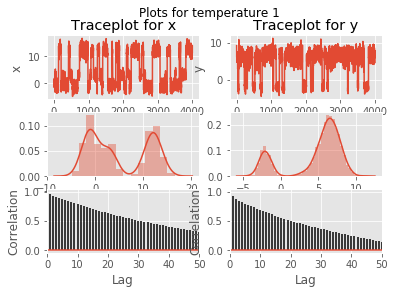

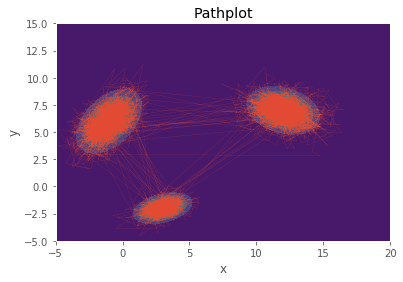

In [101]:
burnin = 10000
plot_trace(foo[:, :, 1], 1)

> **C3**. How do your samples in **C2** compare to those of the Metropolis sampler?  How do they compare to the samples generated from the Gaussian Mixture approximation of $f(x, y)$?

The samples look a lot better than the standard Metropolis sampler: the particle is able to change between the different peaks and so explores the distribution more fully. On the other hand, it also stays quite located at the places of high density and does not wander of far from the peaks.

The marginals look pretty much the same as the Gaussian Mixture (which is a good sign).

## Part D. Global Optima using Simulated Annealing

We have new-found intuition about how to use temperature to improve our sampling. Lets now tackle the inverse idea: what happens if you sample at a lower temperature than 1. Our visualizations from Part B should indicate to us that the distributions become extremely tightly peaked arounnd their maxima.

If we initialized a metropolis-hastings sampler around an optimum at a really low temperature, it would find us a local minimum. But if we had a higher temperature at the beginning, we can use Metropolis-Hastings sampling at high temperatures to travel around the distribution and find all the peaks (valleys).  Then we will slowly cool down the temperature (which will allow us to escape local optima at higher temperatures) and finally focus us into a particular optimum region and allow you to find the optimum. It can be shown that for ceratin *temperture schedules* this method is guaranteed to find us a global minimum in the limit of infinite iterations.

We'll use this methd to find the global minimum of our distribution. The algorithm is as follows. Now we have only one chain, but we very slowly dial down its temperature to below T=1.

1. Initialize $(x, y)_i,T, L(T)$ where $L$ is the number of iterations at a particular temperature. 
2. Perform $L$ transitions thus(we will call this an epoch):
    1. Generate a new proposed position $(x, y)_{\ast}$ using 2 independent gaussians with $\sigma=1$.
    2. If $(x, y)_{\ast}$ is accepted (according to probability $P = e^{(-\Delta E/T)}$, set $(x, y)_{i+1} = (x, y)_{\ast}$, else set $(x, y)_{i+1} = x_{i}$  
3. Update T and L 
4. Until some fixed number of epochs, or until some stop criterion is fulfilled, goto 2.

$\Delta E$ is the change in enery, or the change in the negative log of the probability function. That is, $E = -log p(x,y)$. For a given T and L, this is just Metropolis!

This algorithm is called *simulated annealing* and we'll use it to find the global maximum for $f(X)$

**D1**. Use simulated annealing with a cooling schedule of $T_{k+1}=0.98T_{k}$ and a L(T) defined initially at 100 with $L_{k+1} = 1.2 L_k$ to find the global optima for $p(x, y)$.  Plot $E(x, y)$ vs iterations.  Given how we constructed $p(x, y)$ it should be fairly straight-forward to observe the  true optima by inspection.  How does the optima found by SA compare to the true optima?

As "some other criterion" we use that the relative change in E is less than some $\epsilon$.

In [102]:
qdraw = lambda x, y: np.random.normal(loc=(x, y), scale=1, size=2)

def simulated_annealing(p, qdraw, x_init=(5, 4),T_init=1.0, L_init=100,
                        T_damp=0.98, L_rescale=1.2, n_epoch=1000, eps=10e-6):
    """
    Simmulated annealing to find the optimium of the function `p`. New points are proposed from `qdraw`.
    
    :param p: function to be optimized
    :param qdraw: function to gernate proposal
    :param x_init: inital value of chain
    :param T_init: initial temperate
    :param L_init: initial number of iterations per temperature
    :param T_damp: dampening for temperature
    :param L_rescale: number by which number of iterations at temperature is rescaled
    :param n_epoch: maximum number of epochs
    :param eps: minimum relative improvement
    """
    L = L_init
    T = T_init
    epoch = 0
    energy_trace = []
    trace = [x_init]
    
    run = True
    x = x_init
    delta_E = lambda x, y, T: 1/T * np.log(p(x[0], x[1])) - 1/T * np.log(p(y[0], y[1]))
    
    
    while run:
        E_init = - np.log(p(x[0], x[1]))
        energy_trace.append(E_init)
        
        for _ in range(L):
            x_prop = qdraw(x[0], x[1])
            Δx = delta_E(x_prop, x, T)
            if np.log(np.random.uniform()) < Δx:
                x = x_prop
            
                
        E_final = - np.log(p(x[0], x[1]))
        
        
        ΔE = np.abs((E_final - E_init)/E_init)
        run = epoch < n_epoch and ΔE > eps
        
        L *= int(L_rescale)
        T *= T_damp
        epoch += 1
        trace.append(x)
    
    energy_trace.append(E_final)
    return x, energy_trace, np.array(trace)
            

Text(0.5, 1.0, 'Epoch vs energy')

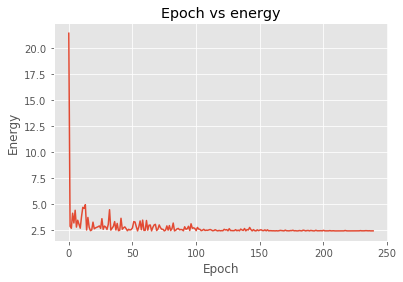

In [103]:
opt, energy_trace, trace = simulated_annealing(p, qdraw)
plt.plot(energy_trace)
plt.xlabel("Epoch")
plt.ylabel("Energy")
plt.title("Epoch vs energy")

Text(0.5, 1.0, 'Epoch vs energy')

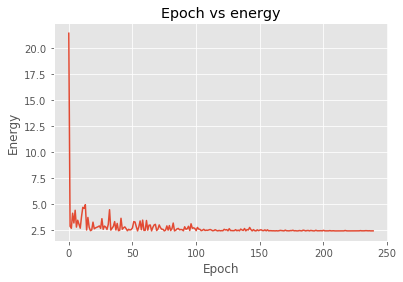

In [104]:
plt.plot(energy_trace)
plt.xlabel("Epoch")
plt.ylabel("Energy")
plt.title("Epoch vs energy")

It's a bit dependent on luck and initial position of the particle whether we got to a local or a global optimum. The closer we start at the global optimum $(12, 7)$, the higher the chance of ending up there. We can maybe try starting at a higher initial temperature than 1:

Text(0.5, 1.0, 'Epoch vs energy')

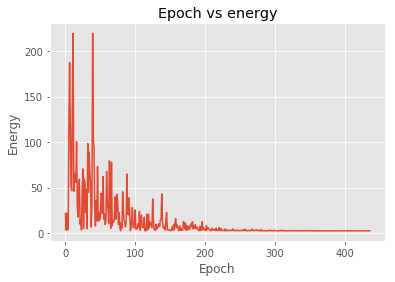

In [105]:
opt, energy_trace, trace = simulated_annealing(p, qdraw, T_init=100)
plt.plot(energy_trace)
plt.xlabel("Epoch")
plt.ylabel("Energy")
plt.title("Epoch vs energy")

In [106]:
opt

array([-1.07658425,  5.92629254])

Experiments show that even in this case we don't necessarily end up at the global optimum. One reason is probably that the values at the various local optima are not too different.